# Predicting survival for Titanic passengers.

## Introduction.

The RMS Titanic was a British luxury passenger liner that sank in 1912 during its maiden voyage due to a collision with an iceberg while traveling from Southampton to New York. Out of the 2224 people on board, including both passengers and crew, near 1500 died (68% of people aboard).

The aim of this project is to use the a dataset available on Kaggle to build a machine learning model that predicts whether passengers survived or not. For this purpose, I will initially train 7 different machine learning models. Then, I will make predictions for each model. Finally, I will combine all predictions to select the final prediction for each passenger by majority voting among the 7 trained models.

## Libraries.

For this project, I will use the following libraries:

In [715]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

## Data.

I will use the Titanic train data from Kaggle (https://www.kaggle.com/competitions/titanic).

For each passenger, the dataset contains the following variables:
- *PassengerID*.
- *Survived* (not present in the test dataset).
- *Pclass*: Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd).
- *Name*.
- *Sex*.
- *Age*.
- *SibSp*: number of siblings / spouse aboard.
- *Parch*: number of parents / children aboard.
- *Ticket*: Ticket number.
- *Fare*: Passenger fare.
- *Cabin*: Cabin number.
- *Embarked*: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

### Loading data.

In [719]:
titanic_raw_data = pd.read_csv('Titanic_train.csv')

### Describing the data.

In [721]:
# printing a summary of the data
titanic_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [722]:
# shape of the dataset
print(f"Number of rows: {titanic_raw_data.shape[0]}")
print(f"Number of columns: {titanic_raw_data.shape[1]}")

Number of rows: 891
Number of columns: 12


In [723]:
# having a look at the first 5 rows
titanic_raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [724]:
# having a look at the last 5 rows
titanic_raw_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [725]:
# having a look at 10 random rows
titanic_raw_data.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
642,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S
607,608,1,1,"Daniel, Mr. Robert Williams",male,27.0,0,0,113804,30.5000,NaN,S
430,431,1,1,"Bjornstrom-Steffansson, Mr. Mauritz Hakan",male,28.0,0,0,110564,26.5500,C52,S
797,798,1,3,"Osman, Mrs. Mara",female,31.0,0,0,349244,8.6833,NaN,S
187,188,1,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,S
747,748,1,2,"Sinkkonen, Miss. Anna",female,30.0,0,0,250648,13.0000,NaN,S
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,C22 C26,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S
316,317,1,2,"Kantor, Mrs. Sinai (Miriam Sternin)",female,24.0,1,0,244367,26.0000,NaN,S
291,292,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C


From this first look at the dataset, I can see that it contains 891 observations of 12 variables. (891 rows and 12 columns).<br>
There is a mix of numeric, alphanumeric and string variables, with different data types (integer, float, object).<br>
Another observation is that there are missing values for some of the variables, like *Cabin*, *Age* and *Embarked*.

In [727]:
# generating descriptive statistics (continuous variables)
titanic_raw_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [728]:
# generating descriptive statistics (categorical variables)
titanic_raw_data.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


Some observations after this preliminary examination of the data:
- ***PassengerId***: It is a unique numeric identifier for each passenger, with 891 values (*int* data type). Very unlikely to have a direct relationship with survival, so it will be dropped.
- ***Survived***: This is the **target** variable. It is a categorical variable in numeric format (*int* data type), taking the value of 1 for those passengers who survived and 0 for those who did not. The data type should be changed from *int* to *object* (categorical). 38.38% passengers in this dataset survived (this is a bit higher than the actual survival rate for all passengers aboard the Titanic, which was ~32%).
- ***Pclass***: It is a categorical variable (ordinal) in numeric format (*int* data type), taking the values of 1, 2 and 3 for 1<sup>st</sup>, 2<sup>nd</sup> and 3<sup>rd</sup> class, respectively. It is an indicator of the socio-economic status of each passenger (upper, middle and lower class).
- ***Age***: Numeric continuous variable (*float* data type). The youngest passenger was 5 months old, while the oldest was 80. The average age of passengers on board was 29.7 years old. 75% of passengers were 38 years old or younger. Finally, I can also see that there are some missing values in this column (there are 714 values for a total of 891 rows).
- ***SibSp***: Numeric discrete variable (*int* data type), with a minimum value of 0 and a maximum of 8. More than half of the passengers did not have siblings or spouse aboard.
- ***Parch***: Numeric discrete variable (*int* data type), with a minimum value of 0 and a maximum of 6. More than half of the passengers did not have parents / children aboard.
- ***Fare***: Numeric continuous variable (*float* data type). The average price paid was £32.20. Most of the passengers (75%) paid £31 or less, with some paying as much as £512.33. This suggests the presence of outliers for this variable.
- ***Name***: Categorical variable with 891 unique values. Very unlikely that it has a direct relationship with survival, so it will be dropped. However, before doing that, it could be used to estimate the missing values of the *Age* column by using the title on the name. After that, it will be dropped.
- ***Sex***: Categorical variable that takes 2 unique values: *male* and *female*. I can also see that 577 of the 891 passengers aboard were men (64.76%).
- ***Ticket***: Alphanumeric variable. It is the ticket number of each passenger and it contains 681 unique values with none missing. This indicates the presence of a relatively large number of duplicated values (24%). Also, it is unlikely that it is directly related to survival, so it will be dropped.
- ***Cabin***: Alphanumeric variable with a very large proportion of missing values (77% of the rows). Due to the high proportion of missing values, I will drop this column.
- ***Embarked***: Categorical variable with 3 unique values, being *S* the most frequent one, with 644 observations. This means that a majority of passengers embarked in Southampton. Also, there are 2 missing values in this column.

## Data cleaning.

From the initial inspection of the data (above), I could see that there are missing values for some of the columns. Also, some data types need to be changed. Finally, before creating the model, I will drop the variables that are not needed. 

In [732]:
# copy of the raw data to work on
titanic_data = titanic_raw_data.copy()

### Missing values.

In [734]:
titanic_data.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

As seen above, there are 687 missing values for the variable *Cabin*, 177 for *Age* and 2 for *Embarked*. Since I will drop the column *Cabin*, I will not address these missing values. Therefore, I will focus on imputing the missing values in the *Age* and *Embarked* columns.

In [736]:
# creating a list of columns to drop
cols_to_drop = ['PassengerId', 'Cabin', 'Ticket']

#### Age.

I will impute the missing values in this column by using the median age, taking into consideration other variables, such as passenger class, sex and the title extracted from the passenger's name.

In [739]:
# extracting the title from the name in a new column called Title
titanic_data['Title'] = titanic_data['Name'].str.extract(r'([A-Za-z]+)\.', expand = False)

# checking the creation of the new column
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [740]:
# counting the observations for the column title
titanic_data['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

Based on these observations, 5 groups can be created (*Mr*, *Mrs*, *Miss*, *Master*, *Other*).

In [742]:
# grouping values of the Title column that belong together
titanic_data['Title'] = titanic_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
titanic_data['Title'] = titanic_data['Title'].replace('Mme', 'Mrs')
titanic_data['Title'] = titanic_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady',\
                                                       'Major', 'Rev', 'Sir'], 'Other')

# counting the observations
titanic_data['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64

Next, I will explore whether there are differences in the median age for each group taking passenger class and sex into consideration.

In [744]:
titanic_data.groupby(['Pclass', 'Sex', 'Title'])['Age'].agg(['median'])

median
Pclass Sex    Title         
1      female Miss      30.0
              Mrs       40.0
              Other     48.0
       male   Master     4.0
              Mr        40.0
              Other     49.0
2      female Miss      24.0
              Mrs       32.0
       male   Master     1.0
              Mr        31.0
              Other     46.5
3      female Miss      18.0
              Mrs       31.0
       male   Master     4.0
              Mr        26.0

There are some differences between the different groups, so I will use this information to impute missing values in the column *Age*.

In [746]:
# creating the series to impute the missing values by using the median age by title, sex and passenger class
median_age_by_title_and_sex = titanic_data.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform('median')

# imputing the missing values for the Age column
titanic_data['Age'] = titanic_data['Age'].fillna(median_age_by_title_and_sex)

# checking that the imputation was successful
titanic_data['Age'].isnull().sum()

0

After doing this, I can include the columns *Name* and *Title* in the list of columns to drop, as I will not use them to create the model.

In [748]:
cols_to_drop.extend(['Name', 'Title'])

#### Embarked.

There are 2 missing values in this column. The most logical approach to me is to use the mode to impute the missing values. To do this, I will use the information in other columns, such as passenger class, to carry out this imputation using a similar approach as above. However, given the small number of missing values in this column, I could try a different approach by searching information about these passengers and then use existing passenger lists to fill these values.

In [751]:
# mode for the Embarked column depending on passenger class
titanic_data.groupby(['Pclass'])['Embarked'].apply(lambda x: x.mode().iloc[0])

Pclass
1    S
2    S
3    S
Name: Embarked, dtype: object

In [752]:
# passengers with missing port of embarkation
titanic_data[titanic_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


I can see that these 2 missing values for the variable *Embarked* correspond to 2 women travelling in 1<sup>st</sup> class who travelled with the same ticket number. After a quick search, I found that these 2 passengers are indeed related and embarked in the port of Southampton (https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html), which also coincides with the mode. Therefore, I will fill these missing values using this information.

In [754]:
# filling the missing values with an 'S'
titanic_data['Embarked'] = titanic_data['Embarked'].fillna('S')

# checking that there are no missing values left
titanic_data['Embarked'].isnull().sum()

0

In [755]:
# checking the correct imputation
titanic_data[titanic_data['PassengerId'].isin([62, 830])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S,Mrs


### Dropping unnecessary columns.

In [757]:
titanic_data = titanic_data.drop(cols_to_drop, axis = 1)

# checking the dataset
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Exploratory data analysis.

### Women and children first?

An unwritten rule or code of conduct in life-threatening situations is that women and children are usually prioritised during evacuation. Was this the case for the Titanic sinking as well? To explore this, I will start by examining survival rates based on gender.

In [761]:
pd.crosstab(titanic_data['Sex'], titanic_data['Survived'], normalize = 0)

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


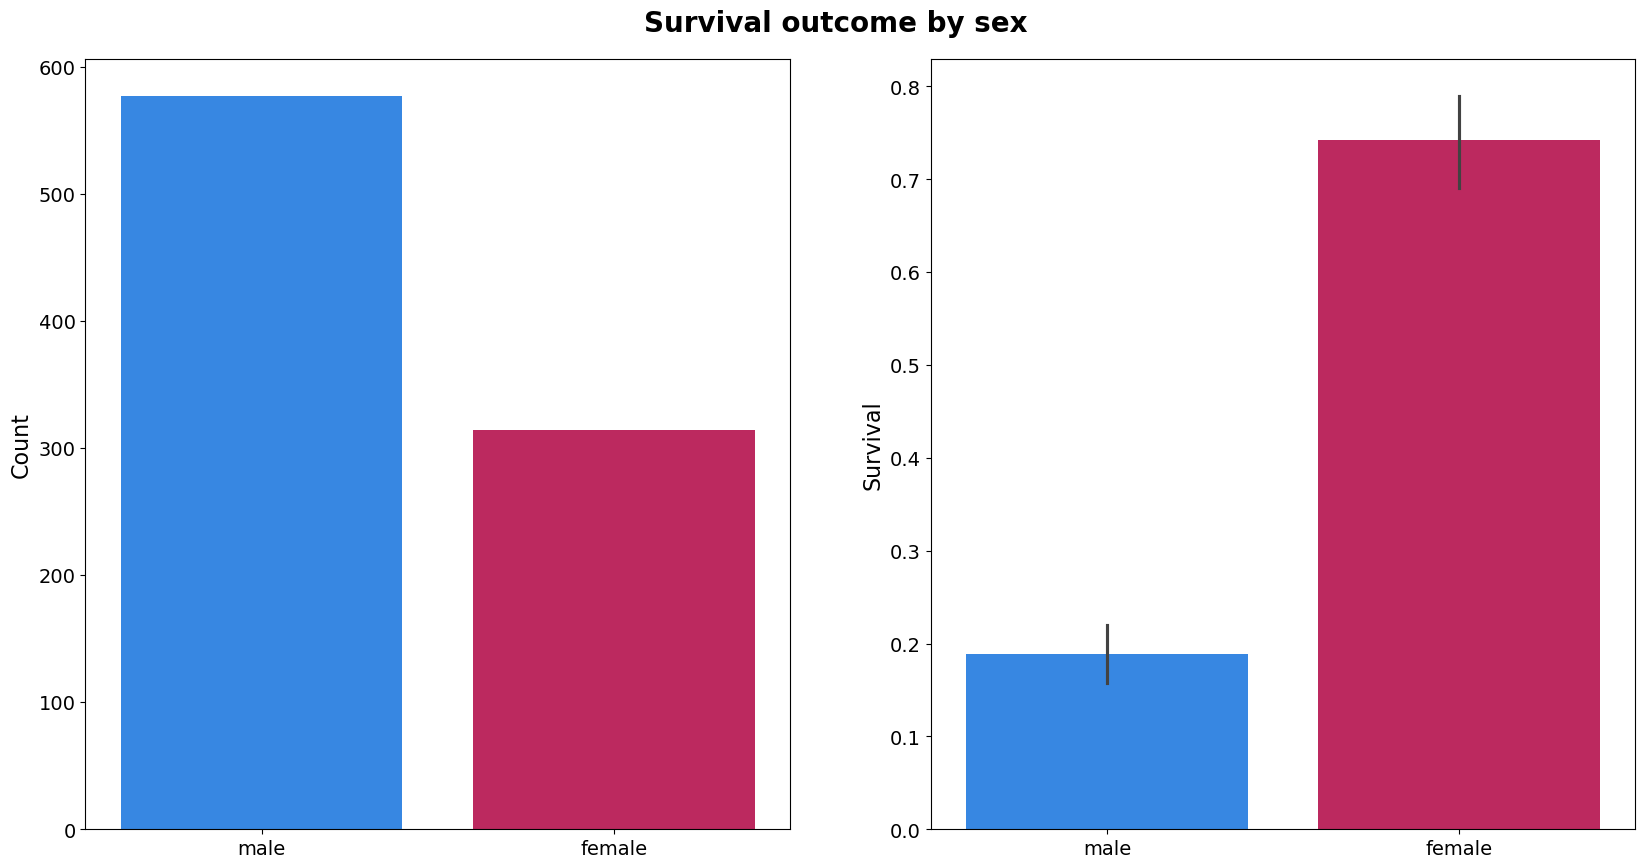

In [762]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

sns.countplot(data = titanic_data,
             x = 'Sex',
             hue = 'Sex',
             palette = {'male': '#1a85ff', 'female': '#d41159'},
             ax = ax[0])

ax[0].set_xlabel('')
ax[0].set_ylabel('Count', fontsize = 16)
ax[0].tick_params(axis = 'both', labelsize = 14)

sns.barplot(data = titanic_data,
           x = 'Sex',
           y = 'Survived',
           hue = 'Sex',
           palette = {'male': '#1a85ff', 'female': '#d41159'},
           ax = ax[1])

ax[1].set_xlabel('')
ax[1].set_ylabel('Survival', fontsize = 16)
ax[1].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Survival outcome by sex', fontsize = 20, fontweight = 'bold', y = 0.93)

plt.show()

As shown above, there are more men than women in the dataset. However, the survival rate for women is significantly higher than for men (74.20% vs. 18.89%). This observation supports the assumption that women were prioritised during evacuation. It also suggests a direct relationship between the variables *Survived* and *Sex*. This hypothesis is further confirmed with a Chi-Square test (p-value < 0.001, see below).

In [764]:
# Chi-Square test for survival and sex
chi2, p, dof, exp = chi2_contingency(pd.crosstab(titanic_data['Sex'], titanic_data['Survived']))

# printing results
print('Results of the Chi-square test:')
print(f"Chi-Square statistic: {chi2}")
print(f"p-value: {p}")

Results of the Chi-square test:
Chi-Square statistic: 260.71702016732104
p-value: 1.197357062775565e-58


Was this the case for children as well? To answer this question, I will start by examining the age distribution in survivors and non-survivors.

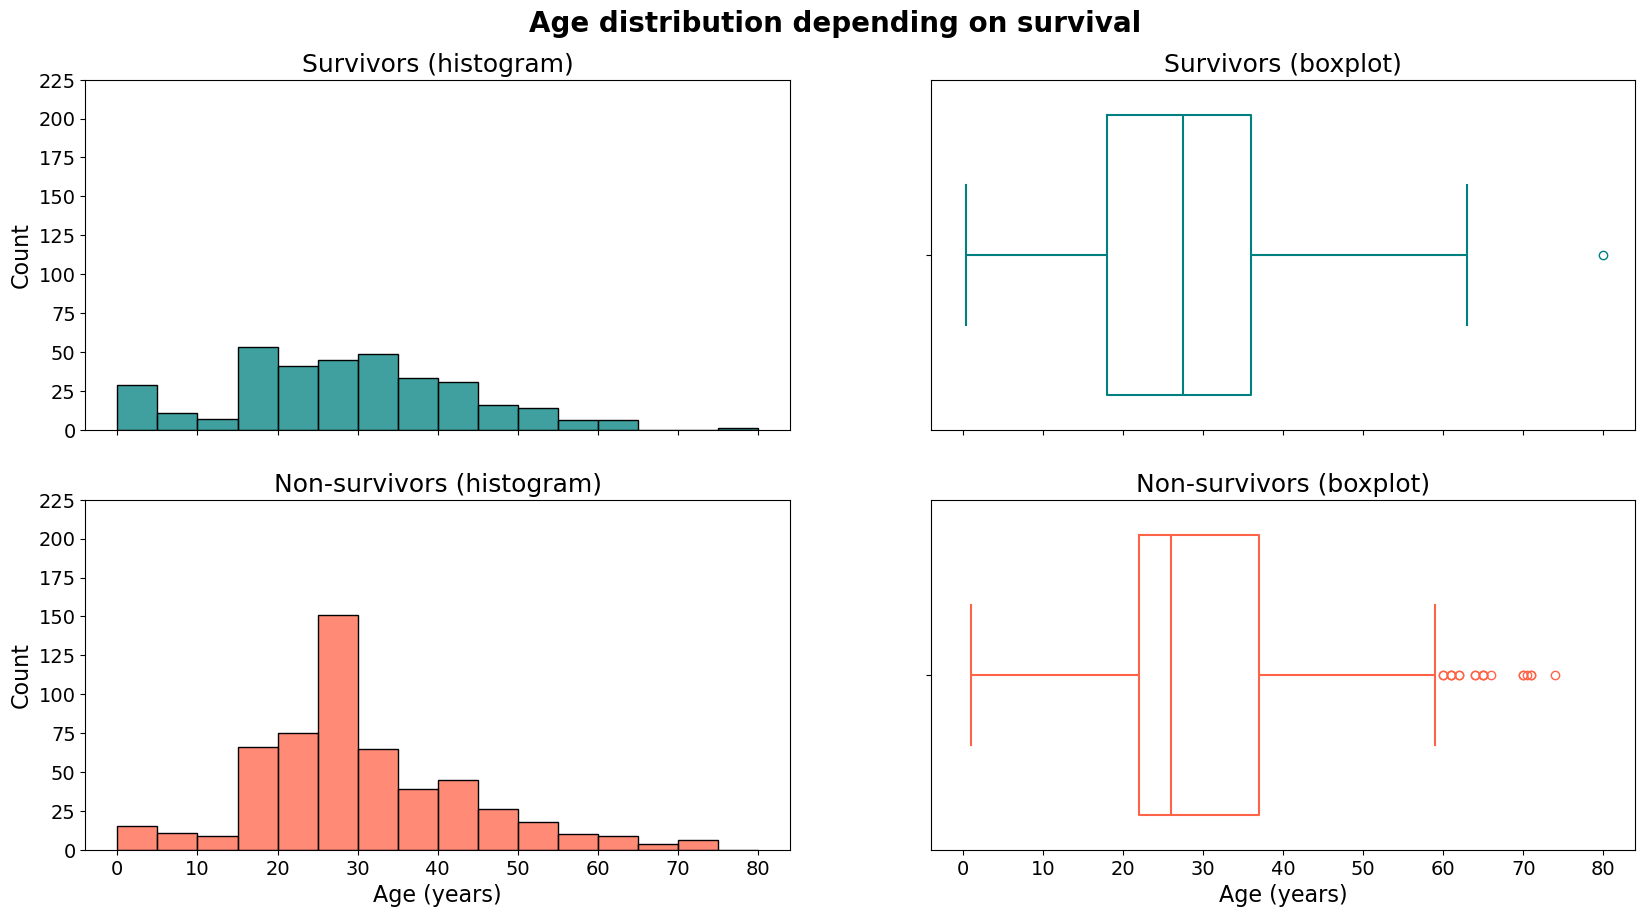

In [766]:
# plotting Age distribution depending on survival status
fig, ax = plt.subplots(2, 2, figsize = (20, 10), sharex = True)

# survived - histogram
sns.histplot(data = titanic_data[titanic_data['Survived'] == 1],
             x = 'Age',
             bins = range(0, 81, 5),
             color = 'teal',
             ax = ax[0, 0])

ax[0, 0].set_title('Survivors (histogram)', fontsize = 18)
ax[0, 0].set_ylabel('Count', fontsize = 16)
ax[0, 0].tick_params(axis = 'both', labelsize = 14)
ax[0, 0].set_ylim(0, 225)

# did not survived - histogram
sns.histplot(data = titanic_data[titanic_data['Survived'] == 0],
             x = 'Age',
             bins = range(0, 81, 5),
             color = 'tomato',
             ax = ax[1, 0])

ax[1, 0].set_title('Non-survivors (histogram)', fontsize = 18)
ax[1, 0].set_xlabel('Age (years)', fontsize = 16)
ax[1, 0].set_ylabel('Count', fontsize = 16)
ax[1, 0].tick_params(axis = 'both', labelsize = 14)
ax[1, 0].set_ylim(0, 225)


# boxplot survived - boxplot
sns.boxplot(data = titanic_data[titanic_data['Survived'] == 1],
             x = 'Age',
             color = 'teal',
             fill = False,
             ax = ax[0, 1])

ax[0, 1].set_title('Survivors (boxplot)', fontsize = 18)


# boxplot did not survive - boxplot
sns.boxplot(data = titanic_data[titanic_data['Survived'] == 0],
             x = 'Age',
             color = 'tomato',
             fill = False,
             ax = ax[1, 1])

ax[1, 1].set_title('Non-survivors (boxplot)', fontsize = 18)
ax[1, 1].set_xlabel('Age (years)', fontsize = 16)
ax[1, 1].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Age distribution depending on survival', fontsize = 20, fontweight = 'bold', y = 0.95)
plt.show()

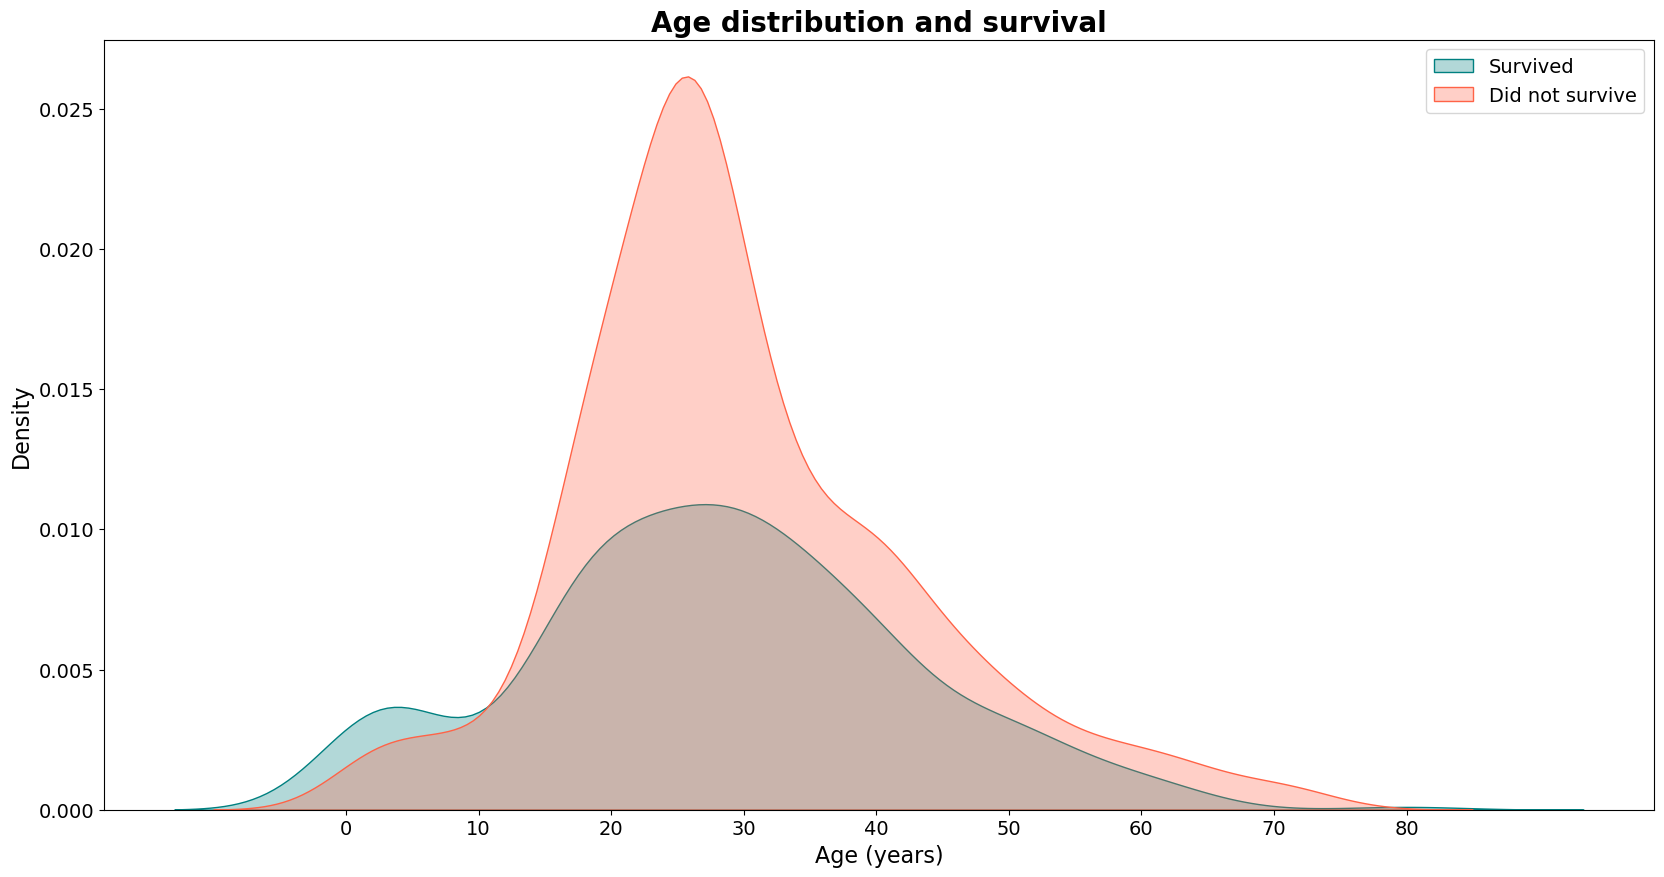

In [767]:
# kde plot
plt.figure(figsize = (20, 10))

sns.kdeplot(data = titanic_data,
           x = 'Age',
           hue = 'Survived',
           hue_order = [0, 1],
           palette = {0: 'tomato', 1: 'teal'},
           fill = True,
           alpha = 0.3)

plt.xticks(list(range(0, 81, 10)))
plt.title('Age distribution and survival', fontsize = 20, fontweight = 'bold')
plt.xlabel('Age (years)', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(['Survived', 'Did not survive'], fontsize = 14)
plt.show()

In [768]:
# survival frequencies by age (intervals of 5 years)
pd.crosstab(pd.cut(titanic_data['Age'], bins = [0, 15, 81], include_lowest = True, right = True),\
            titanic_data['Survived'], normalize = 0)

Survived,0,1
Age,,
"(-0.001, 15.0]",0.413793,0.586207
"(15.0, 81.0]",0.638060,0.361940


As seen above, the majority of passengers in the dataset are between 15 and 45 years old. Children aged 15 or younger had a higher survival rate compared to passengers older than 15. A possible explanation for this observation could be that, as expected, children were prioritised during evacuation along with women. Another factor to consider is the composition of this age group, potentially with more girls than boys. Therefore, I will have a closer look at this age group.

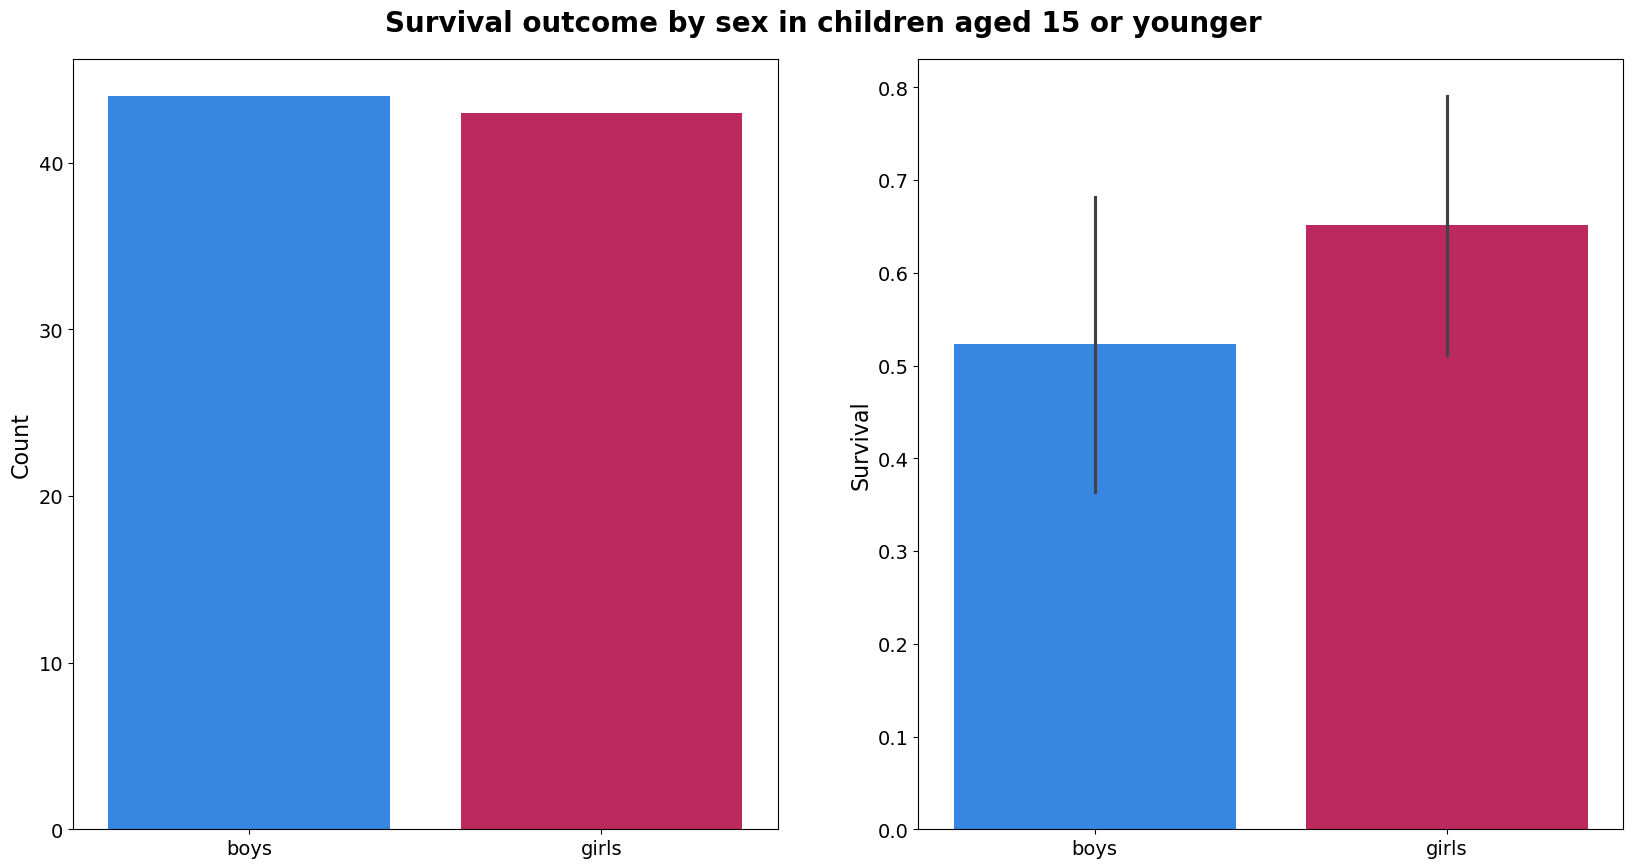

In [770]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

sns.countplot(data = titanic_data[titanic_data['Age'] <= 15],
             x = 'Sex',
             hue = 'Sex',
             palette = {'male': '#1a85ff', 'female': '#d41159'},
             ax = ax[0])

ax[0].set_xlabel('')
ax[0].set_ylabel('Count', fontsize = 16)
ax[0].set_xticks([0, 1], ['boys', 'girls'])
ax[0].tick_params(axis = 'both', labelsize = 14)

sns.barplot(data = titanic_data[titanic_data['Age'] <= 15],
           x = 'Sex',
           y = 'Survived',
           hue = 'Sex',
           palette = {'male': '#1a85ff', 'female': '#d41159'},
           ax = ax[1])

ax[1].set_xlabel('')
ax[1].set_ylabel('Survival', fontsize = 16)
ax[1].set_xticks([0, 1], ['boys', 'girls'])
ax[1].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Survival outcome by sex in children aged 15 or younger', fontsize = 20, fontweight = 'bold', y = 0.93)

plt.show()

As shown above, the number of boys and girls in this age group is almost the same. While it seems that the survival rate for girls is a bit higher than for boys, this difference is not statistically significant (p-value = 0.32, see below). In addition, boys aged 15 years or younger still had a higher survival rate than older passengers.

In [772]:
# Chi-Square test for survival and sex (children with age <= 15 years old)
chi2, p, dof, exp = chi2_contingency(pd.crosstab(titanic_data[titanic_data['Age'] <= 15]['Sex'], titanic_data['Survived']))

# printing results
print('Results of the Chi-square test:')
print(f"Chi-Square statistic: {chi2}")
print(f"p-value: {p}")

Results of the Chi-square test:
Chi-Square statistic: 0.9968073778137041
p-value: 0.3180842641226717


In conclusion, it seems that the age was a factor that had a direct impact on survival, with passengers aged 15 or younger having higher chances to survive.

### What about families?

The observations above suggest the possibility that passengers travelling with family members had a higher survival rate than those travelling alone. To investigate this, I will create a new variable (*IsAlone*) that indicates whether a passenger was travelling alone or not. For this purpose, I will use the variables *SibSp* and *Parch*. If a passenger had no siblings, spouse, parents, or children aboard (i.e., both *SibSp* and *Parch* are 0), the new variable *IsAlone* will be set to 1. Otherwise, it will be set to 0.

In [776]:
# creating the new variable IsAlone that takes the value of 1 if the passenger had no siblings/spouse/children/parents aboard
titanic_data['IsAlone'] = np.where((titanic_data['SibSp'] == 0) & (titanic_data['Parch'] == 0), 1, 0)

# checking the creation of the new variable
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone
0,0,3,male,22.0,1,0,7.2500,S,0
1,1,1,female,38.0,1,0,71.2833,C,0
2,1,3,female,26.0,0,0,7.9250,S,1
3,1,1,female,35.0,1,0,53.1000,S,0
4,0,3,male,35.0,0,0,8.0500,S,1


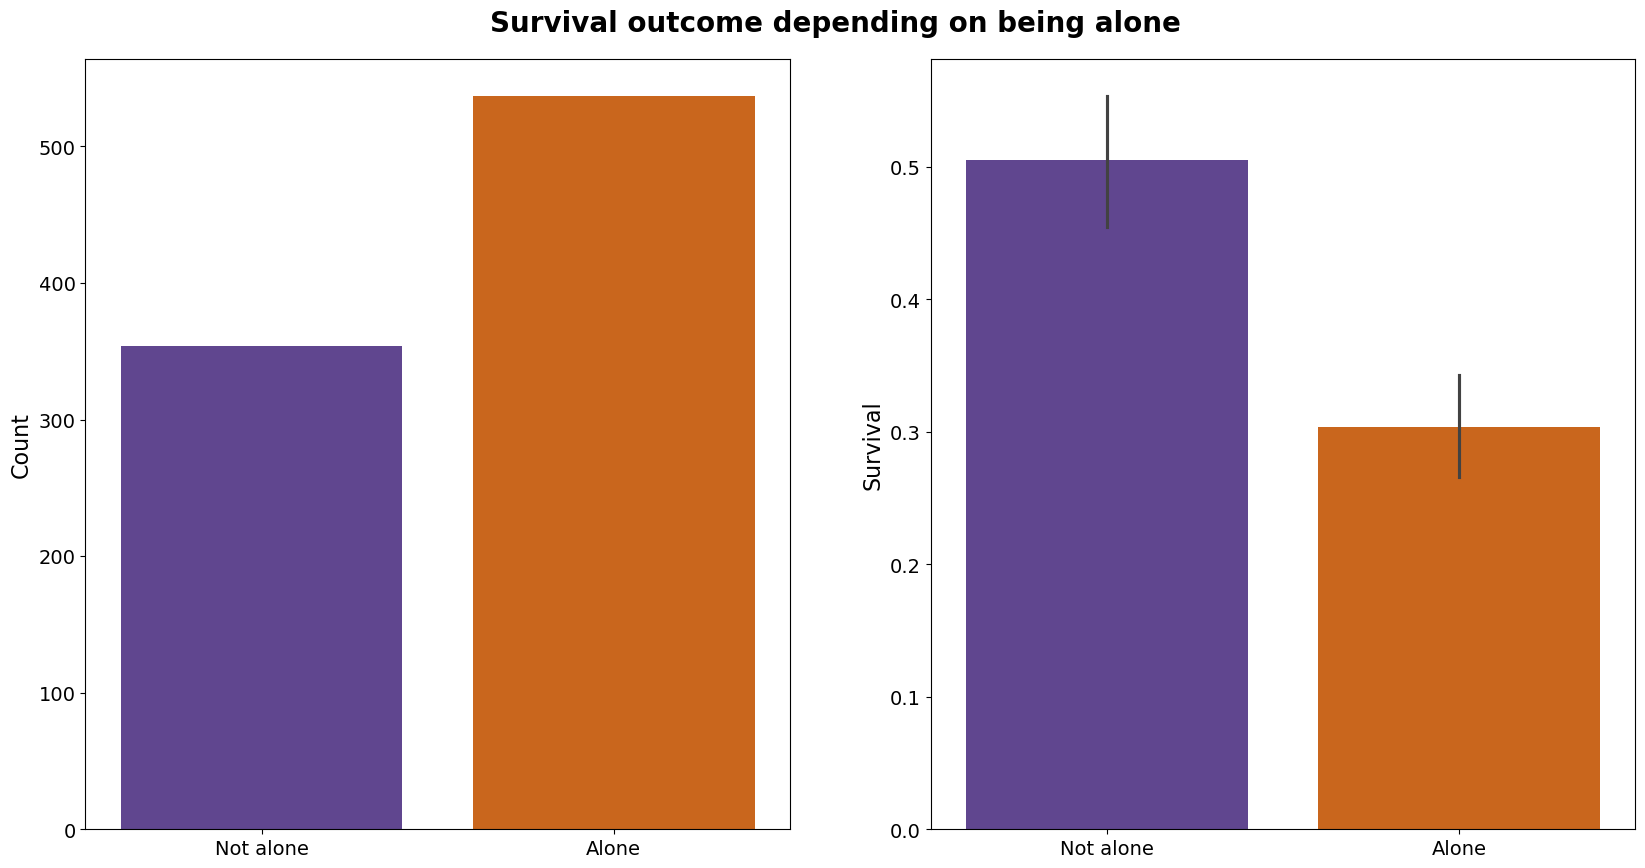

In [777]:
# passengers travelling alone vs. with family members
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

sns.countplot(data = titanic_data,
             x = 'IsAlone',
             hue = 'IsAlone',
             palette = {1: '#e66100', 0: '#5d3a9b'},
             legend = False,
              ax = ax[0])

ax[0].set_xlabel('')
ax[0].set_ylabel('Count', fontsize = 16)
ax[0].set_xticks([0, 1], ['Not alone', 'Alone'])
ax[0].tick_params(axis = 'both', labelsize = 14)

sns.barplot(data = titanic_data,
           x = 'IsAlone',
           y = 'Survived',
           hue = 'IsAlone',
           palette = {1: '#e66100', 0: '#5d3a9b'},
           legend = False,
           ax = ax[1])

ax[1].set_xlabel('')
ax[1].set_ylabel('Survival', fontsize = 16)
ax[1].set_xticks([0, 1], ['Not alone', 'Alone'])
ax[1].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Survival outcome depending on being alone', fontsize = 20, fontweight = 'bold', y = 0.93)

plt.show()

In [778]:
pd.crosstab(titanic_data['IsAlone'], titanic_data['Survived'], normalize = 0)

Survived,0,1
IsAlone,,
0,0.494350,0.505650
1,0.696462,0.303538


In the dataset, the majority of passengers travelled alone (>500). Notably, they had a significantly lower survival rate compared to those passengers travelling with at least one family member (30.35% vs. 50.57%). Thus, it seems that having a family member aboard had a positive impact on survival. However, did the number of relatives aboard also influence survival? Was it the same for those travelling with 1 relative as for those travelling with 4, for example? To answer this question, I will examine the survival rate based on the number relatives a passenger had aboard.

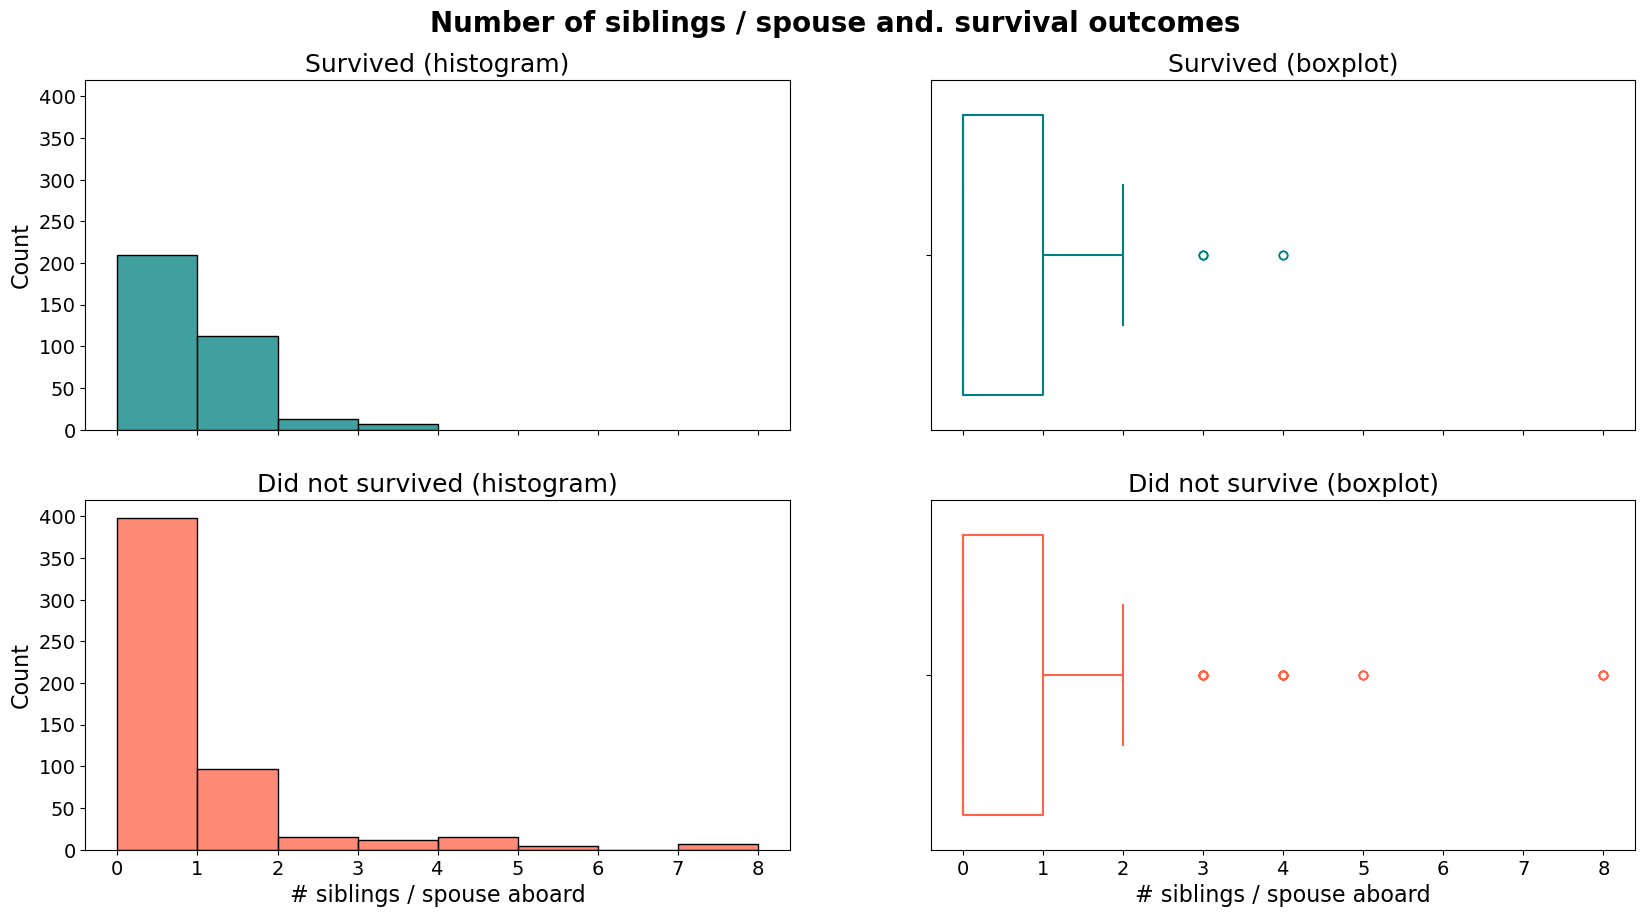

In [780]:
# plotting number of siblings / spouse distribution depending on survival status
fig, ax = plt.subplots(2, 2, figsize = (20, 10), sharex = True)

# passengers that survived - histogram
sns.histplot(data = titanic_data[titanic_data['Survived'] == 1],
             x = 'SibSp',
             binwidth = 1,
             color = 'teal',
             ax = ax[0, 0])

ax[0, 0].set_title('Survived (histogram)', fontsize = 18)
ax[0, 0].set_ylabel('Count', fontsize = 16)
ax[0, 0].tick_params(axis = 'both', labelsize = 14)
ax[0, 0].set_ylim(0, 420)

# passengers that did not survived - histogram
sns.histplot(data = titanic_data[titanic_data['Survived'] == 0],
             x = 'SibSp',
             binwidth = 1,
             color = 'tomato',
             ax = ax[1, 0])

ax[1, 0].set_title('Did not survived (histogram)', fontsize = 18)
ax[1, 0].set_ylabel('Count', fontsize = 16)
ax[1, 0].set_xlabel('# siblings / spouse aboard', fontsize = 16)
ax[1, 0].tick_params(axis = 'both', labelsize = 14)
ax[1, 0].set_ylim(0, 420)


# boxplot survived - boxplot
sns.boxplot(data = titanic_data[titanic_data['Survived'] == 1],
             x = 'SibSp',
             color = 'teal',
             fill = False,
             ax = ax[0, 1])

ax[0, 1].set_title('Survived (boxplot)', fontsize = 18)


# boxplot did not survive - boxplot
sns.boxplot(data = titanic_data[titanic_data['Survived'] == 0],
             x = 'SibSp',
             color = 'tomato',
             fill = False,
             ax = ax[1, 1])

ax[1, 1].set_title('Did not survive (boxplot)', fontsize = 18)
ax[1, 1].set_xlabel('# siblings / spouse aboard', fontsize = 16)
ax[1, 1].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Number of siblings / spouse and. survival outcomes', fontsize = 20, fontweight = 'bold', y = 0.95)

plt.show()

In [781]:
pd.crosstab(titanic_data['SibSp'], titanic_data['Survived'], normalize = 0)

Survived,0,1
SibSp,,
0,0.654605,0.345395
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,0.000000
8,1.000000,0.000000


As seen above, having 1-2 siblings / spouse aboard increased the chances of survival (53.59% survival rate for passengers having 1 sibling/spouse, 46.43% for those with 2, vs. 34.54% for those with none, 25% for passengers with 3, 16.67% for those with 4, and 0% for those having more).

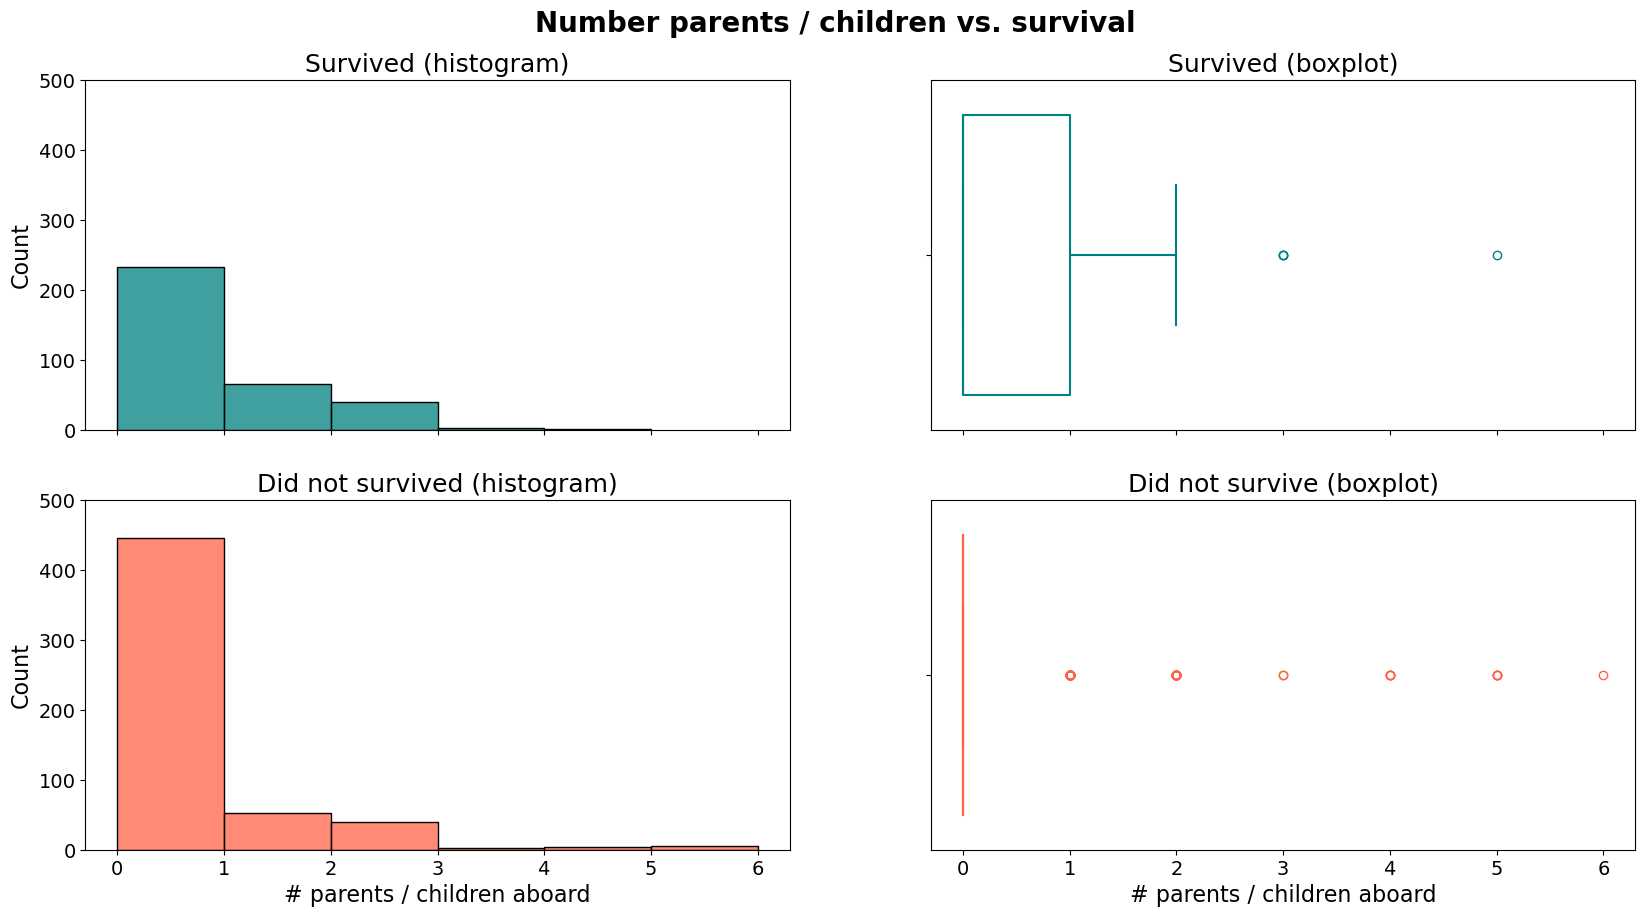

In [783]:
# distribution of the # parents / children depending on survival status

fig, ax = plt.subplots(2, 2, figsize = (20, 10), sharex = True)

# passengers who survived - histogram
sns.histplot(data = titanic_data[titanic_data['Survived'] == 1],
             x = 'Parch',
             binwidth = 1,
             color = 'teal',
             ax = ax[0, 0])

ax[0, 0].set_title('Survived (histogram)', fontsize = 18)
ax[0, 0].set_ylabel('Count', fontsize = 16)
ax[0, 0].tick_params(axis = 'both', labelsize = 14)
ax[0, 0].set_ylim(0, 500)

# passengers who did not survived
sns.histplot(data = titanic_data[titanic_data['Survived'] == 0],
             x = 'Parch',
             binwidth = 1,
             color = 'tomato',
             ax = ax[1, 0])

ax[1, 0].set_title('Did not survived (histogram)', fontsize = 18)
ax[1, 0].set_xlabel('# parents / children aboard', fontsize = 16)
ax[1, 0].set_ylabel('Count', fontsize = 16)
ax[1, 0].tick_params(axis = 'both', labelsize = 14)
ax[1, 0].set_ylim(0, 500)


# boxplot survived - boxplot
sns.boxplot(data = titanic_data[titanic_data['Survived'] == 1],
             x = 'Parch',
             color = 'teal',
             fill = False,
             ax = ax[0, 1])

ax[0, 1].set_title('Survived (boxplot)', fontsize = 18)


# boxplot did not survive - boxplot
sns.boxplot(data = titanic_data[titanic_data['Survived'] == 0],
             x = 'Parch',
             color = 'tomato',
             fill = False,
             ax = ax[1, 1])

ax[1, 1].set_title('Did not survive (boxplot)', fontsize = 18)
ax[1, 1].set_xlabel('# parents / children aboard', fontsize = 16)
ax[1, 1].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Number parents / children vs. survival', fontsize = 20, fontweight = 'bold', y = 0.95)
plt.show()

In [784]:
pd.crosstab(titanic_data['Parch'], titanic_data['Survived'], normalize = 0)

Survived,0,1
Parch,,
0,0.656342,0.343658
1,0.449153,0.550847
2,0.500000,0.500000
3,0.400000,0.600000
4,1.000000,0.000000
5,0.800000,0.200000
6,1.000000,0.000000


Similar conclusions can be drawn when looking at the survival rate based on how many parents/children each passenger was travelling with. Passengers travelling with 1-3 children/parents had the highest survival rate (50-60%).

To summarise the previous observations and have a better picture regarding the total number the relatives aboard, I will create a new variable called *RelativesAboard*. This variable will indicate how many siblings/spouse/parents/children each passenger was travelling with.

In [787]:
# summarising by creating a new variable: family size (SibSp + Parch)
titanic_data['RelativesAboard'] = titanic_data['SibSp'] + titanic_data['Parch']

# checking the creation of the new variable
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,RelativesAboard
0,0,3,male,22.0,1,0,7.2500,S,0,1
1,1,1,female,38.0,1,0,71.2833,C,0,1
2,1,3,female,26.0,0,0,7.9250,S,1,0
3,1,1,female,35.0,1,0,53.1000,S,0,1
4,0,3,male,35.0,0,0,8.0500,S,1,0


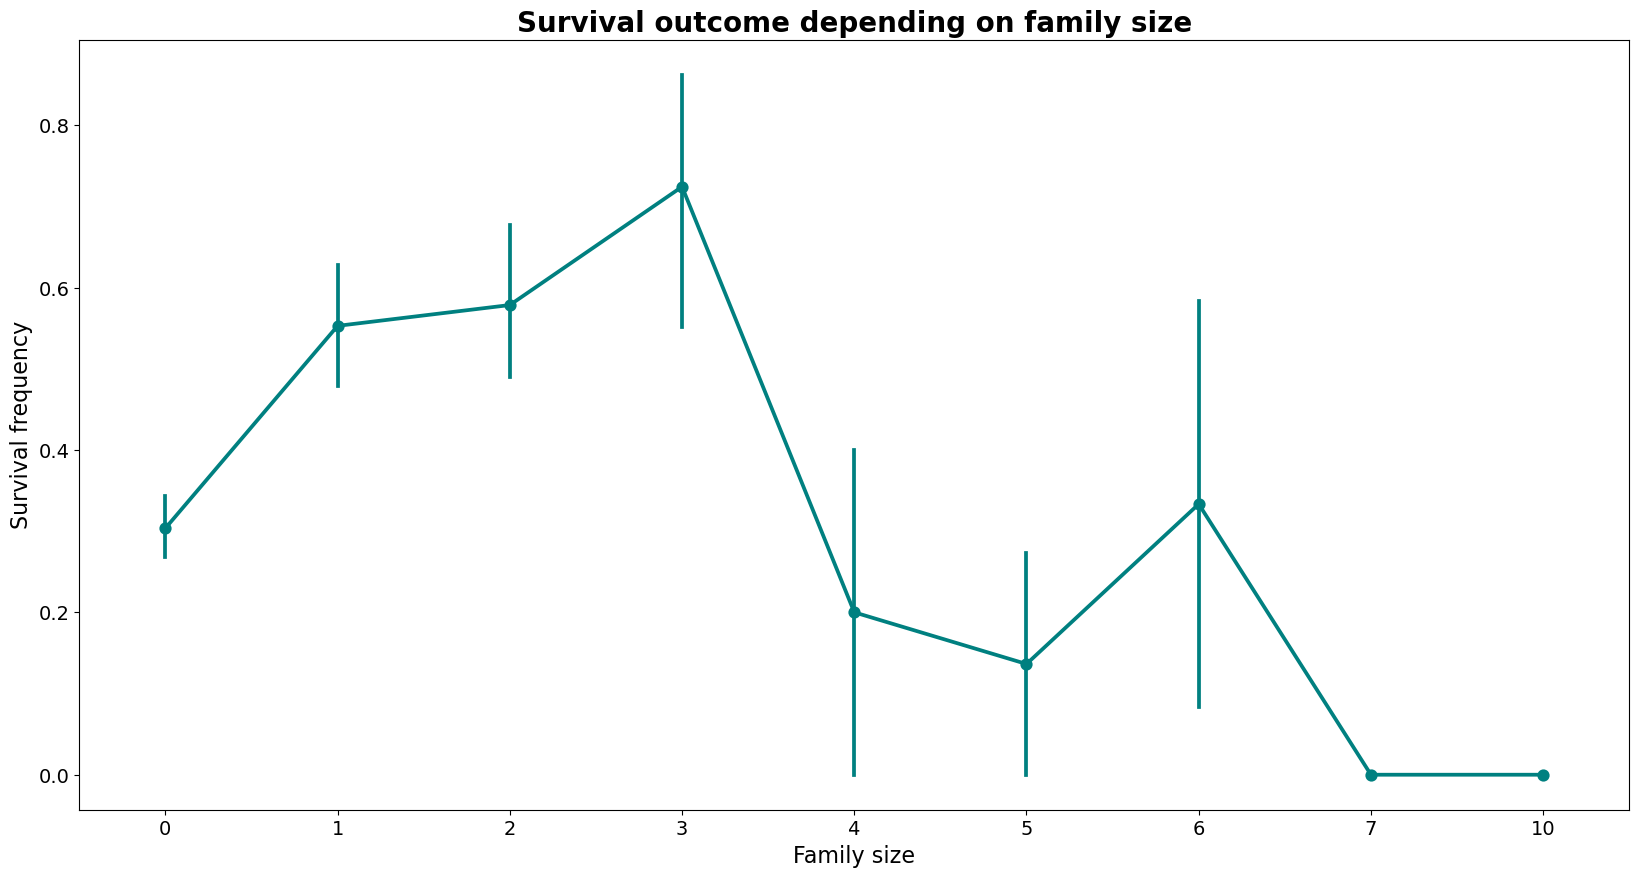

In [788]:
# plotting survival outcomes depending on family size
plt.figure(figsize = (20, 10))

sns.pointplot(data = titanic_data,
             x = 'RelativesAboard',
             y = 'Survived',
             color = 'teal')

plt.title('Survival outcome depending on family size', fontsize = 20, fontweight = 'bold')
plt.xlabel('Family size', fontsize = 16)
plt.ylabel('Survival frequency', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 14)
plt.show()

Passengers travelling with 1-3 other family members generally had a higher survival rate. Travelling with more than 3 relatives (or with none) decreased the chances of survival, possibly due to the increased number of family members to attend during evacuation. Can the same conclusions be drawn if this graph is segregated by gender?

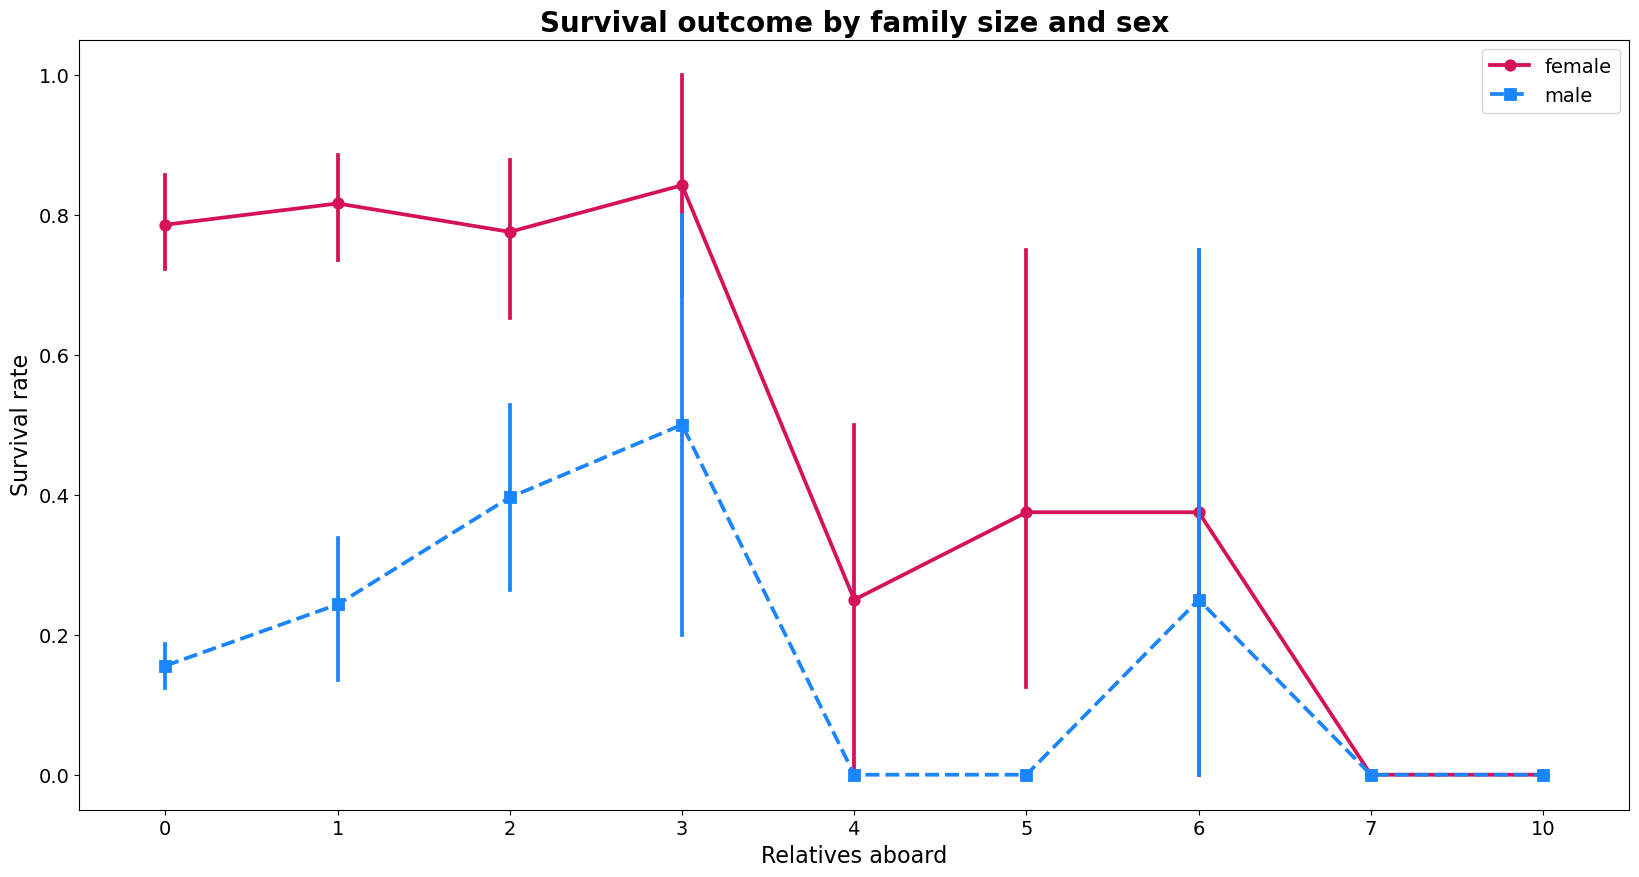

In [790]:
# survival by family size and sex
plt.figure(figsize = (20, 10))

sns.pointplot(data = titanic_data,
             x = 'RelativesAboard',
             y = 'Survived',
             hue = 'Sex',
             palette = {'male': '#1a85ff', 'female': '#d41159'},
             linestyles = ['-', '--'],
             markers = ['o', 's'])

plt.title('Survival outcome by family size and sex', fontsize = 20, fontweight = 'bold')
plt.xlabel('Relatives aboard', fontsize = 16)
plt.ylabel('Survival rate', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(fontsize = 14)
plt.show()

When segregating by gender, women travelling alone had the same survival rate as women travelling with 1-3 relatives. Aside from this observation, the rest of the conclusions are similar to those in the previous graph.<br>
In regards to men, the graph above shows a higher survival rate for those travelling with 2-3 other family members (although the error bar for the group with 3 is quite large). A possible explanation for this is that these men were travelling with small children (aged 15 or less), so they were among those passengers prioritised during evacuation.<br>
In conclusion, there seems to be a direct relationship between the survival rate and the number of relatives a passenger travelled with.

### Does money matter?

Did the socio-economic status have an impact on survival? To address this question, I will first examine the variable *Pclass*, which is a proxy for the socio-economic status of the passengers, and its relationship with survival.

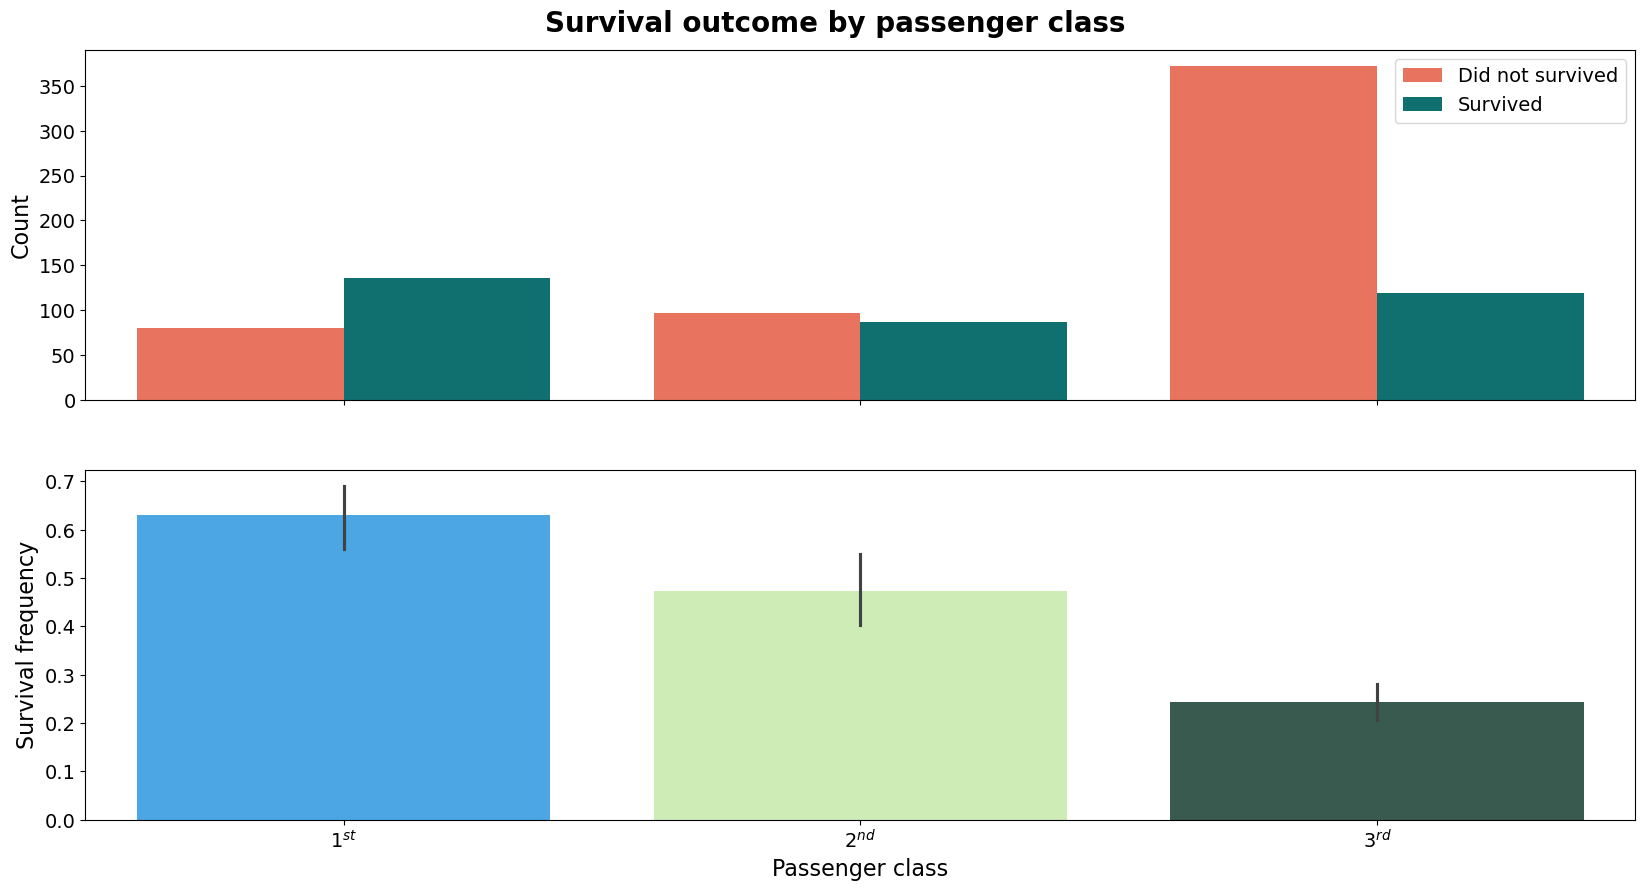

In [794]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10), sharex = True)

# count plot
sns.countplot(data = titanic_data,
             x = 'Pclass', 
             hue = 'Survived',
             order = [1, 2, 3],
             palette = {0: 'tomato', 1: 'teal'},
             ax = ax[0])

ax[0].set_ylabel('Count', fontsize = 16)
ax[0].tick_params(axis = 'both', labelsize = 14)
ax[0].legend(['Did not survived', 'Survived'], fontsize = 14)

# point plot
sns.barplot(data = titanic_data,
           x = 'Pclass',
           y = 'Survived',
           hue = 'Pclass',
           palette = {1: '#32abfe', 2: '#cdf5ac', 3: '#345f4f'},
           legend = False,
           ax = ax[1])

ax[1].set_xlabel('Passenger class', fontsize = 16)
ax[1].set_xticks([0, 1, 2], ['$1^{st}$', '$2^{nd}$', '$3^{rd}$'])
ax[1].set_ylabel('Survival frequency', fontsize = 16)
ax[1].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Survival outcome by passenger class', fontsize = 20, fontweight = 'bold', y = 0.92)
plt.show()

In [795]:
pd.crosstab(titanic_data['Pclass'], titanic_data['Survived'], normalize = 0)

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


As seen above, passengers travelling in 1<sup>st</sup> class had the highest survival rate among the 3 passenger classes (62.96%), followed by passengers travelling in 2<sup>nd</sup> class (47.28%). The majority of passengers in the dataset travelled in 3<sup>rd</sup> class, which had the lowest survival rate (24.24%). There could be different explanations for this observation, one of them being a higher proportion of women and children travelling in 1<sup>st</sup> class and less in 3<sup>rd</sup>. To investigate whether this was indeed the case, I will explore this further.

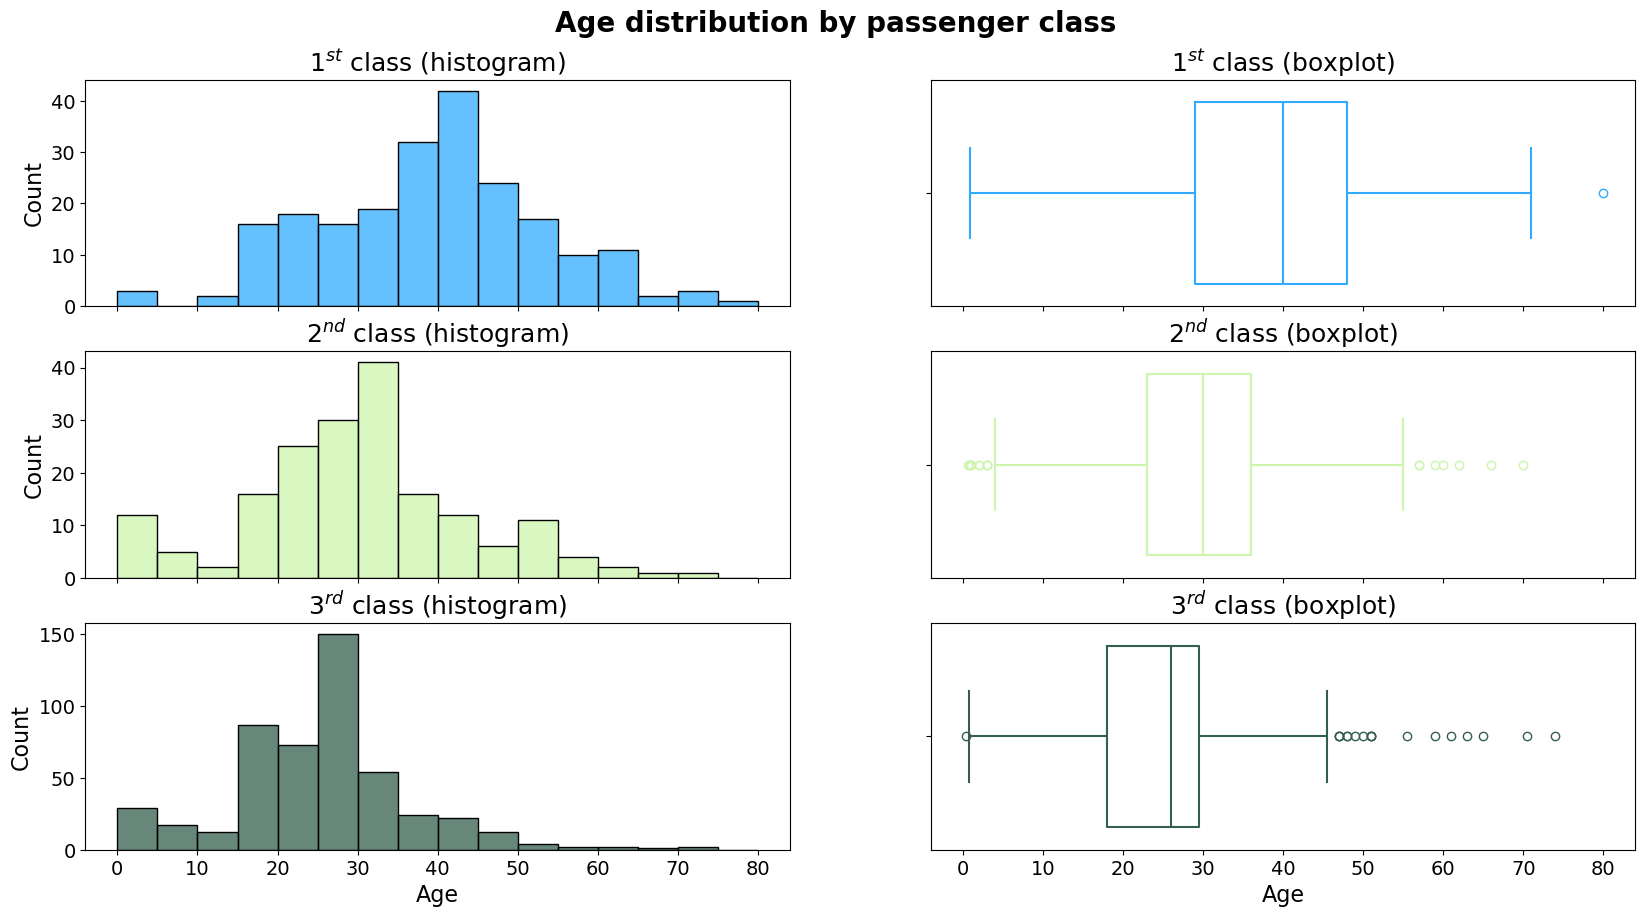

In [797]:
fig, ax = plt.subplots(3, 2, figsize = (20, 10), sharex = True)

sns.histplot(data = titanic_data[titanic_data['Pclass'] == 1],
            x = 'Age',
            bins = range(0, 81, 5),
            color = '#32abfe',
            ax = ax[0, 0])

ax[0, 0].set_title('$1^{st}$ class (histogram)', fontsize = 18)
ax[0, 0].set_ylabel('Count', fontsize = 16)
ax[0, 0].tick_params(axis = 'both', labelsize = 14)

sns.boxplot(data = titanic_data[titanic_data['Pclass'] == 1],
           x = 'Age',
           color = '#32abfe',
           fill = False,
           ax = ax[0, 1])

ax[0, 1].set_title('$1^{st}$ class (boxplot)', fontsize = 18)

sns.histplot(data = titanic_data[titanic_data['Pclass'] == 2],
            x = 'Age',
            bins = range(0, 81, 5),
            color = '#cdf5ac',
            ax = ax[1, 0])

ax[1, 0].set_title('$2^{nd}$ class (histogram)', fontsize = 18)
ax[1, 0].set_ylabel('Count', fontsize = 16)
ax[1, 0].tick_params(axis = 'both', labelsize = 14)

sns.boxplot(data = titanic_data[titanic_data['Pclass'] == 2],
           x = 'Age',
           color = '#cdf5ac',
           fill = False,
           ax = ax[1, 1])

ax[1, 1].set_title('$2^{nd}$ class (boxplot)', fontsize = 18)

sns.histplot(data = titanic_data[titanic_data['Pclass'] == 3],
            x = 'Age',
            bins = range(0, 81, 5),
            color = '#345f4f',
            ax = ax[2, 0])

ax[2, 0].set_title('$3^{rd}$ class (histogram)', fontsize = 18)
ax[2, 0].set_xlabel('Age', fontsize = 16)
ax[2, 0].set_ylabel('Count', fontsize = 16)
ax[2, 0].tick_params(axis = 'both', labelsize = 14)

sns.boxplot(data = titanic_data[titanic_data['Pclass'] == 3],
           x = 'Age',
           color = '#345f4f',
           fill = False,
           ax = ax[2, 1])

ax[2, 1].set_title('$3^{rd}$ class (boxplot)', fontsize = 18)
ax[2, 1].set_xlabel('Age', fontsize = 16)
ax[2, 1].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Age distribution by passenger class', fontsize = 20, fontweight = 'bold', y = 0.95)

plt.show()

In [798]:
# number of children aged 15 or younger and passengers aged 16+ in the different passenger classes
pd.crosstab(titanic_data['Pclass'], pd.cut(titanic_data['Age'], bins = [0, 15, 81], include_lowest = True, right = True))

Age,"(-0.001, 15.0]","(15.0, 81.0]"
Pclass,,
1,6,210
2,19,165
3,62,429


In [799]:
# proportion of children (15 years old or younger) in the different passenger classes
pd.crosstab(titanic_data['Pclass'], pd.cut(titanic_data['Age'], bins = [0, 15, 81], include_lowest = True, right = True),\
           normalize = 0)

Age,"(-0.001, 15.0]","(15.0, 81.0]"
Pclass,,
1,0.027778,0.972222
2,0.103261,0.896739
3,0.126273,0.873727


It does not seem that the higher survival rate for passengers travelling in 1<sup>st</sup> class is due to a higher proportion of children aged 15 or younger. In fact, among the 3 passenger classes, the 1<sup>st</sup> class has the oldest passengers on average and the fewest children both in number and proportion (6 children, making up 2.78% of passengers in this class). On the other end, passengers travelling in 3<sup>rd</sup> class were the youngest on average and this class had the highest proportion of children aged 15 or younger (12.63%, 62 children in total). Therefore, could the higher survival rate for 1<sup>st</sup> class-passengers be attributed to a higher proportion of women?

In [801]:
# total number of women in the different classes
pd.crosstab(titanic_data['Pclass'], titanic_data['Sex'])

Sex,female,male
Pclass,,
1,94,122
2,76,108
3,144,347


In [802]:
# proportion of women in the different passenger classes
pd.crosstab(titanic_data['Pclass'], titanic_data['Sex'], normalize = 0)

Sex,female,male
Pclass,,
1,0.435185,0.564815
2,0.413043,0.586957
3,0.293279,0.706721


There are more women in 1<sup>st</sup> class than in the other 2 passenger classes. However, the difference in proportion is very small when compared with 2<sup>nd</sup> class (43.52% vs. 41.3%; p-value > 0.05, see below).

In [804]:
# passengers in 1st and 2nd class
pass_first_second = titanic_data[titanic_data['Pclass'].isin([1, 2])]

# Chi-square test to check the association between passenger class and gender
chi2, p, dof, exp = chi2_contingency(pd.crosstab(pass_first_second['Pclass'], pass_first_second['Sex']))

# results of the test
print('Results of the Chi-square test:')
print(f"Chi2 statistic: {chi2}")
print(f"p-value: {p}")

Results of the Chi-square test:
Chi2 statistic: 0.11902261429671676
p-value: 0.7300969700763549


These observations suggest that the higher survival rate for passengers travelling in 1<sup>st</sup> is not related to a higher proportion of women and children.<br>
Another factor that could explain this higher survival rate for 1<sup>st</sup> class-passengers is a lower proportion of passengers travelling alone, since these have a significantly lower survival rate than the ones travelling with relatives.

In [806]:
pd.crosstab(titanic_data['Pclass'], titanic_data['IsAlone'])

IsAlone,0,1
Pclass,,
1,107,109
2,80,104
3,167,324


In [807]:
pd.crosstab(titanic_data['Pclass'], titanic_data['IsAlone'], normalize = 0)

IsAlone,0,1
Pclass,,
1,0.495370,0.504630
2,0.434783,0.565217
3,0.340122,0.659878


In fact, there is a higher proportion of passengers travelling alone in 3<sup>rd</sup> class (65.99%) than in the other 2 passenger classes, with the 1<sup>st</sup> class having the lowest proportion of passengers travelling alone (50.46%). Thus, this could be one of the factors that explain why there is a higher survival for passengers in 1<sup>st</sup> class.

In [809]:
# passengers travelling alone and with relatives in each class and survival outcome
pd.crosstab([titanic_data['Pclass'], titanic_data['IsAlone']], titanic_data['Survived'])

Survived          0   1
Pclass IsAlone         
1      0         29  78
       1         51  58
2      0         29  51
       1         68  36
3      0        117  50
       1        255  69

In [810]:
# Chi-square to test association between Pclass, IsAlone and Survival
chi2, p, dof, exp = chi2_contingency(pd.crosstab([titanic_data['Pclass'], titanic_data['IsAlone']], titanic_data['Survived']))

# printing results
print('Results of the Chi-square test:')
print(f"Chi2-statistic: {chi2}")
print(f"p-value: {p}")

Results of the Chi-square test:
Chi2-statistic: 131.44677498587544
p-value: 1.1735803035928023e-26


Indeed, a Chi-Square test supports the assumption above, suggesting an association between the variables *Pclass*, *IsAlone* and *Survived* (p-value < 0.001).

Another factor related to money and that could have had an impact on the survival rate is the price paid for the ticket.

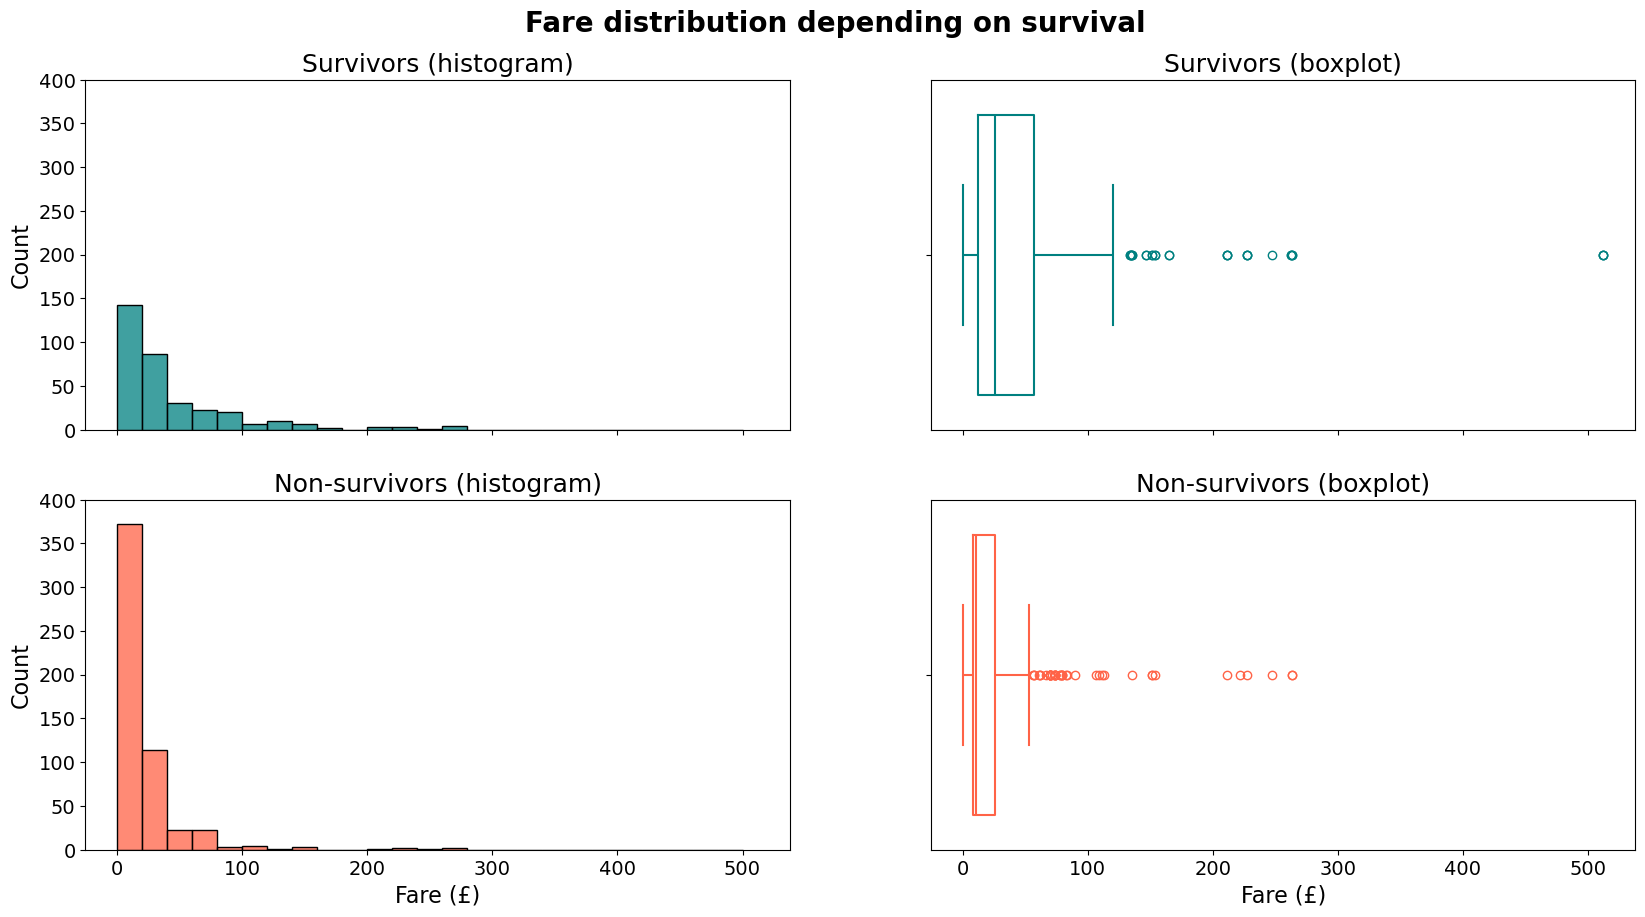

In [813]:
# plotting Fare distribution depending on survival status
fig, ax = plt.subplots(2, 2, figsize = (20, 10), sharex = True)

# survived - histogram
sns.histplot(data = titanic_data[titanic_data['Survived'] == 1],
             x = 'Fare',
             bins = range(0, 520, 20),
             color = 'teal',
             ax = ax[0, 0])

ax[0, 0].set_title('Survivors (histogram)', fontsize = 18)
ax[0, 0].set_ylabel('Count', fontsize = 16)
ax[0, 0].tick_params(axis = 'both', labelsize = 14)
ax[0, 0].set_ylim(0, 400)

# did not survived - histogram
sns.histplot(data = titanic_data[titanic_data['Survived'] == 0],
             x = 'Fare',
             bins = range(0, 520, 20),
             color = 'tomato',
             ax = ax[1, 0])

ax[1, 0].set_title('Non-survivors (histogram)', fontsize = 18)
ax[1, 0].set_xlabel('Fare (£)', fontsize = 16)
ax[1, 0].set_ylabel('Count', fontsize = 16)
ax[1, 0].tick_params(axis = 'both', labelsize = 14)
ax[1, 0].set_ylim(0, 400)


# boxplot survived - boxplot
sns.boxplot(data = titanic_data[titanic_data['Survived'] == 1],
             x = 'Fare',
             color = 'teal',
             fill = False,
             ax = ax[0, 1])

ax[0, 1].set_title('Survivors (boxplot)', fontsize = 18)


# boxplot did not survive - boxplot
sns.boxplot(data = titanic_data[titanic_data['Survived'] == 0],
             x = 'Fare',
             color = 'tomato',
             fill = False,
             ax = ax[1, 1])

ax[1, 1].set_title('Non-survivors (boxplot)', fontsize = 18)
ax[1, 1].set_xlabel('Fare (£)', fontsize = 16)
ax[1, 1].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Fare distribution depending on survival', fontsize = 20, fontweight = 'bold', y = 0.95)
plt.show()

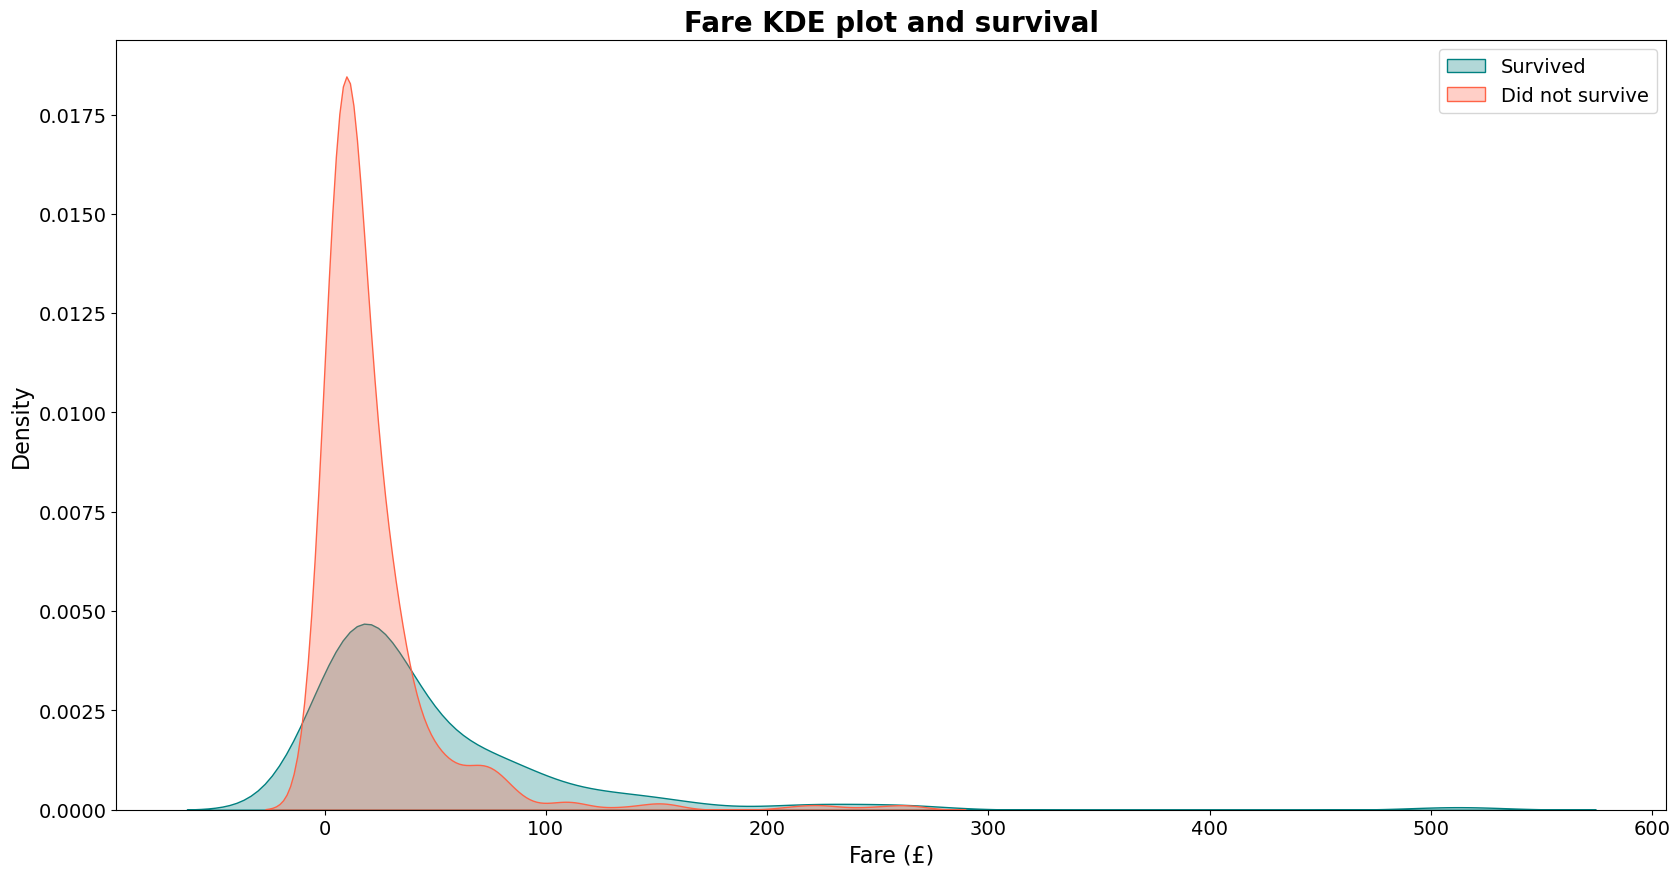

In [814]:
plt.figure(figsize = (20, 10))

sns.kdeplot(data = titanic_data,
           x = 'Fare',
           hue = 'Survived',
           hue_order = [0, 1],
           palette = {0: 'tomato', 1: 'teal'},
           fill = True,
           alpha = 0.3)

plt.title('Fare KDE plot and survival', fontsize = 20, fontweight = 'bold')
plt.xlabel('Fare (£)', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(['Survived', 'Did not survive'], fontsize = 14)
plt.show()

In [815]:
# survival rate by fare group
pd.crosstab(pd.cut(titanic_data['Fare'], bins = list(range(0, 91, 10)) + [float('inf')], include_lowest = True, right = True),\
            titanic_data['Survived'], normalize = 0)

Survived,0,1
Fare,,
"(-0.001, 10.0]",0.800595,0.199405
"(10.0, 20.0]",0.575419,0.424581
"(20.0, 30.0]",0.556338,0.443662
"(30.0, 40.0]",0.603448,0.396552
"(40.0, 50.0]",0.750000,0.250000
"(50.0, 60.0]",0.289474,0.710526
"(60.0, 70.0]",0.647059,0.352941
"(70.0, 80.0]",0.387097,0.612903
"(80.0, 90.0]",0.176471,0.823529


Most passengers paid less than £40 for their ticket. On average, survivors paid a higher amount for their tickets (some even as much as more than £500). A possible explanation for this observation is the higher survival rate of passengers travelling in 1<sup>st</sup> class as it is expected that they paid a higher price for their tickets.

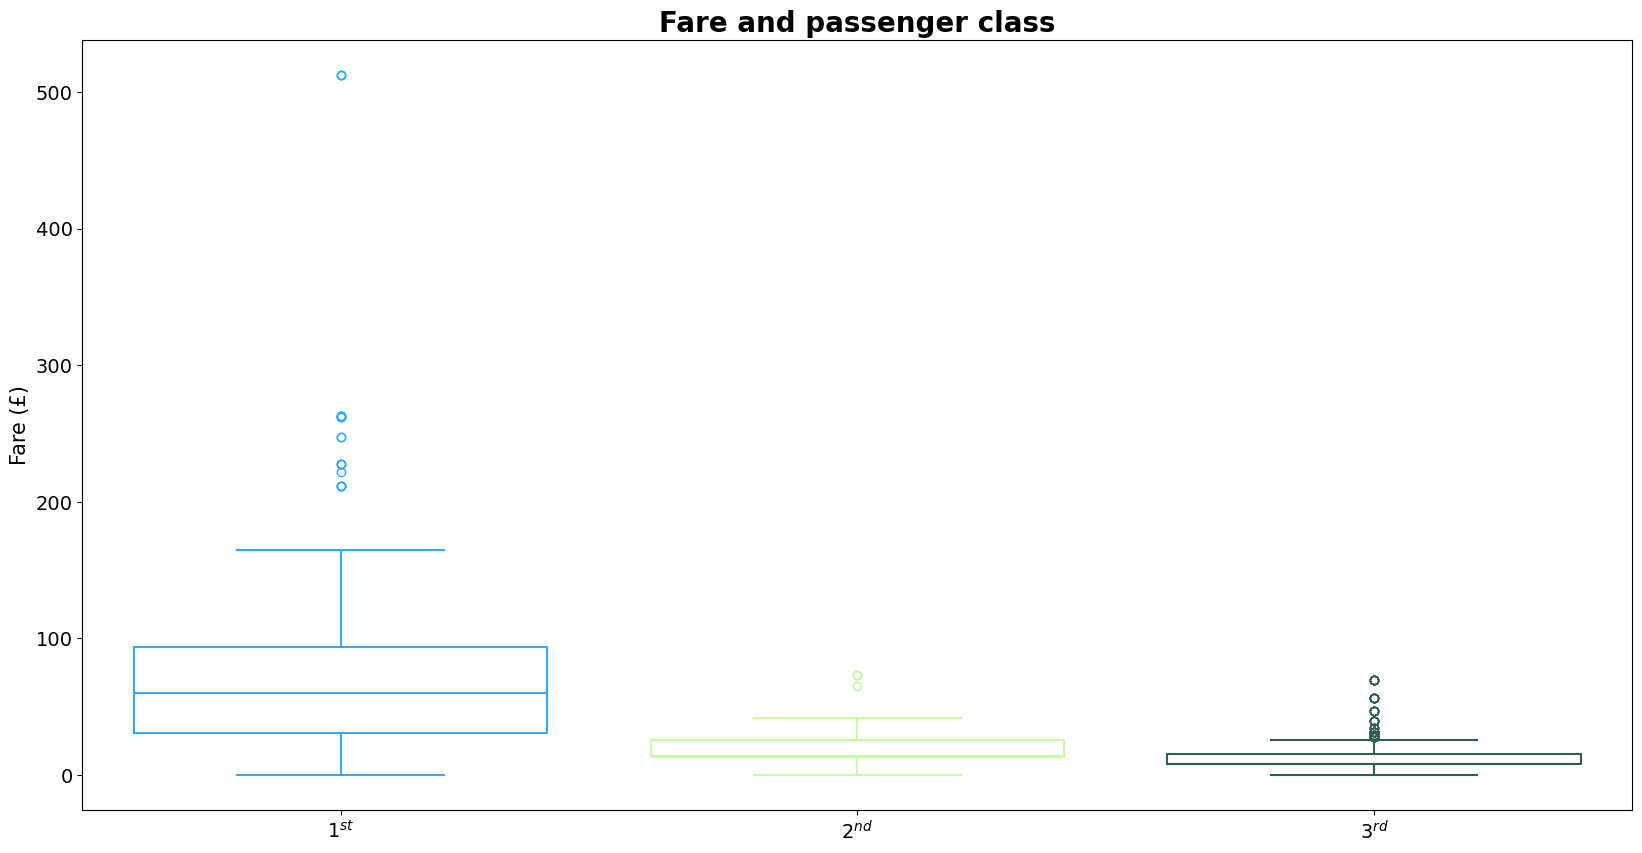

In [817]:
plt.figure(figsize = (20, 10))

sns.boxplot(data = titanic_data,
            x = 'Pclass',
            y = 'Fare',
            hue = 'Pclass',
            palette = {1: '#32abfe', 2: '#cdf5ac', 3: '#345f4f'},
            fill = False,
            legend = False)

plt.title('Fare and passenger class', fontsize = 20, fontweight = 'bold')
plt.xlabel('')
plt.xticks([0, 1, 2], ['$1^{st}$', '$2^{nd}$', '$3^{rd}$'])
plt.ylabel('Fare (£)', fontsize = 15)
plt.tick_params(axis = 'both', labelsize = 14)
plt.show()

In [818]:
# mean fare by passenger class
titanic_data.groupby(['Pclass'])['Fare'].mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

Indeed, passengers travelling in 1<sup>st</sup> class paid, on average, a higher price than those travelling in 2<sup>nd</sup> and 3<sup>rd</sup> classes (these paid the cheapest fares). In addition, there is a noticeable wide range of fare values among these passengers, with some passengers paying more than £500 for their ticket and others not paying anything at all. The latter anomaly can be explained by the fact that some passengers, such as employees of the White Star Line (the operator of the Titanic), received complimentary tickets.<br>
Thus, there seems to be a direct relationship between *Fare* and *Survived*, possibly due to the relationship between *Fare* and *Pclass*.

### Port of embarkation. Were passengers embarking at one port luckier than those embarking in others?

The Titanic's maiden voyage departed from Southampton, with a first stop in the French city of Cherbourg, and followed by another stop in Queenstown (Ireland), before sailing towards New York. Most passengers boarded in Southampton, while Queenstown was the port where the fewest passengers were taken aboard.

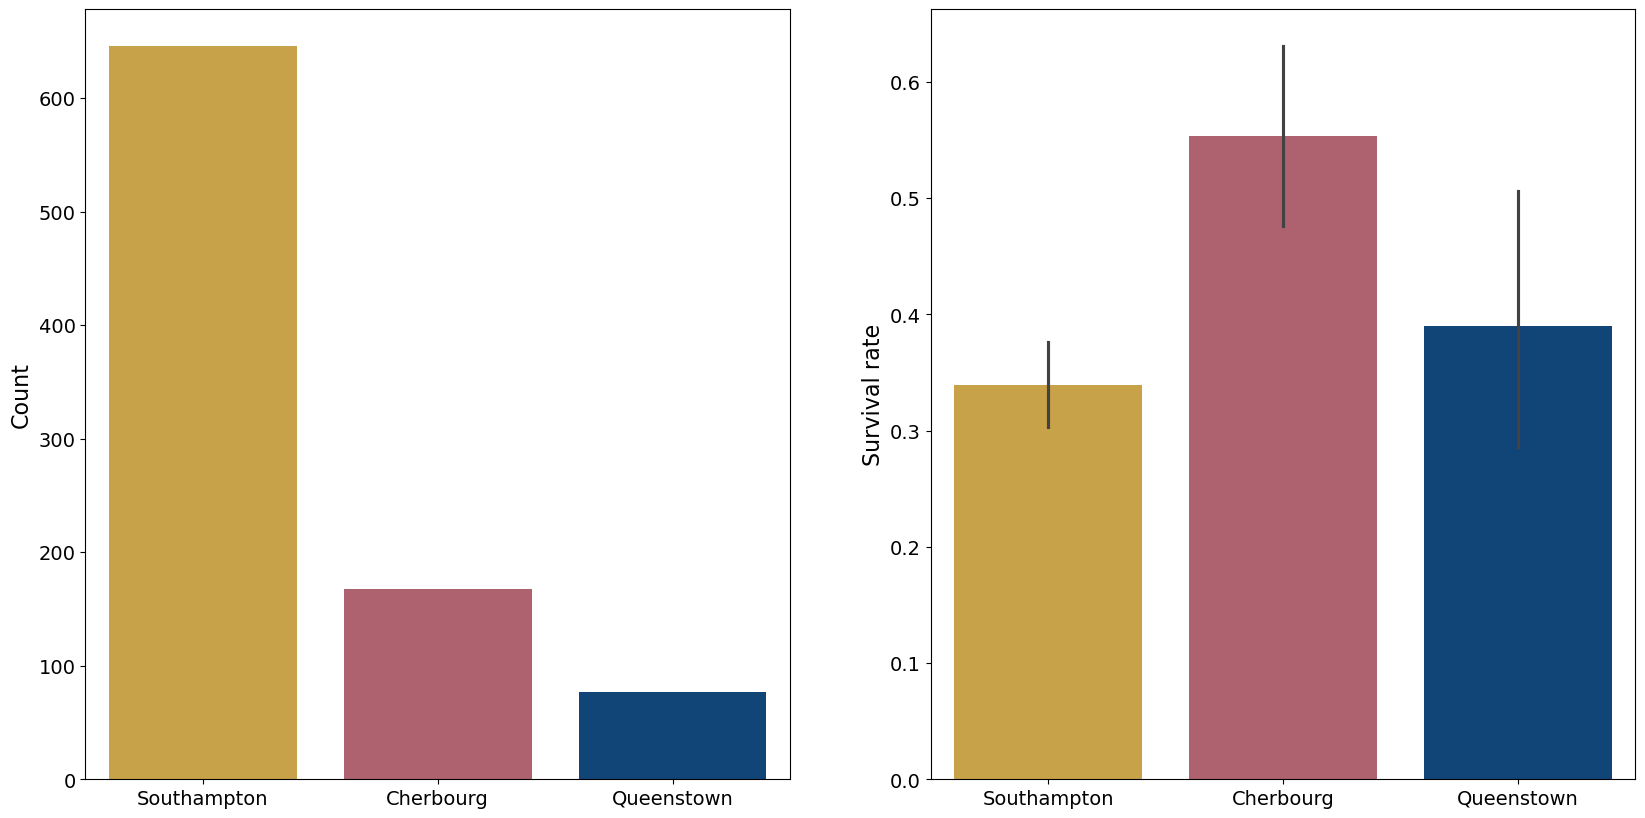

In [822]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

# count plot
sns.countplot(data = titanic_data,
             x = 'Embarked',
             hue = 'Embarked',
             hue_order = ['S', 'C', 'Q'],
             palette = {'S': '#ddaa33', 'C': '#bb5566', 'Q': '#004488'},
             legend = False,
             ax = ax[0])

ax[0].set_xlabel('')
ax[0].set_xticks([0, 1, 2], ['Southampton', 'Cherbourg', 'Queenstown'])
ax[0].set_ylabel('Count', fontsize = 16)
ax[0].tick_params(axis = 'both', labelsize = 14)

# survival rate
sns.barplot(data = titanic_data,
           x = 'Embarked',
           y = 'Survived',
           hue = 'Embarked',
           hue_order = ['S', 'C', 'Q'],
           palette = {'S': '#ddaa33', 'C': '#bb5566', 'Q': '#004488'},
           legend = False,
           ax = ax[1])

ax[1].set_xlabel('')
ax[1].set_xticks([0, 1, 2], ['Southampton', 'Cherbourg', 'Queenstown'])
ax[1].set_ylabel('Survival rate', fontsize = 16)
ax[1].tick_params(axis = 'both', labelsize = 14)

plt.show()

In [823]:
pd.crosstab(titanic_data['Embarked'], titanic_data['Survived'], normalize = 0)

Survived,0,1
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.660991,0.339009


Passengers that embarked in Cherbourg had the highest survival rate (55.36%), significantly higher than the survival rate for passengers embarked in Southampton (33.9%) and Queenstown (38.96%). A possible explanation for this observation could be differences in demographics or socio-economic status among the passengers embarking in the French city.

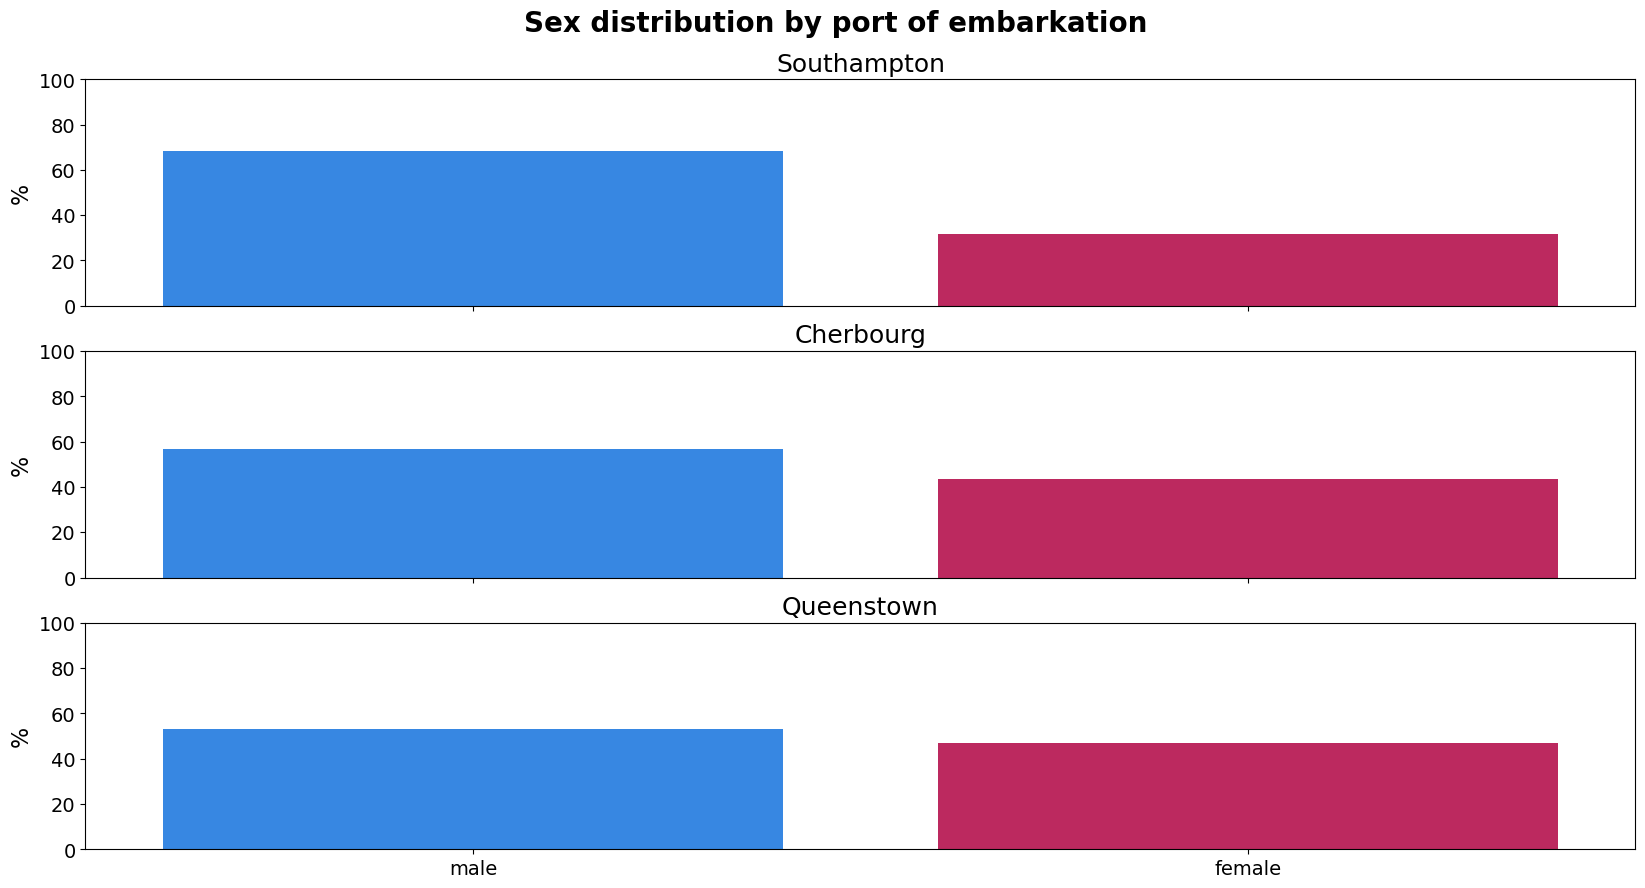

In [825]:
# sex distribution among passengers depending on port of embarkation
fig, ax = plt.subplots(3, 1, figsize = (20, 10), sharex = True)

# Southampton
sns.countplot(data = titanic_data[titanic_data['Embarked'] == 'S'],
              x = 'Sex',
              hue = 'Sex',
              palette = {'male': '#1a85ff', 'female': '#d41159'},
              legend = False,
              stat = 'percent',
              ax = ax[0])

ax[0].set_title('Southampton', fontsize = 18)
ax[0].set_ylabel('%', fontsize = 16)
ax[0].set_ylim(0, 100)
ax[0].tick_params(axis = 'both', labelsize = 14)


# Cherbourg
sns.countplot(data = titanic_data[titanic_data['Embarked'] == 'C'],
              x = 'Sex',
              hue = 'Sex',
              palette = {'male': '#1a85ff', 'female': '#d41159'},
              legend = False,
              stat = 'percent',
              ax = ax[1])

ax[1].set_title('Cherbourg', fontsize = 18)
ax[1].set_ylabel('%', fontsize = 16)
ax[1].set_ylim(0, 100)
ax[1].tick_params(axis = 'both', labelsize = 14)


# Queenstown
sns.countplot(data = titanic_data[titanic_data['Embarked'] == 'Q'],
              x = 'Sex',
              hue = 'Sex',
              palette = {'male': '#1a85ff', 'female': '#d41159'},
              legend = False,
              stat = 'percent',
              ax = ax[2])

ax[2].set_title('Queenstown', fontsize = 18)
ax[2].set_xlabel('')
ax[2].set_ylabel('%', fontsize = 16)
ax[2].set_ylim(0, 100)
ax[2].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Sex distribution by port of embarkation', fontsize = 20, fontweight = 'bold', y = 0.95)

plt.show()

In [826]:
pd.crosstab(titanic_data['Embarked'], titanic_data['Sex'], normalize = 0)

Sex,female,male
Embarked,,
C,0.434524,0.565476
Q,0.467532,0.532468
S,0.317337,0.682663


The proportion of women embarking in Queenstown was the largest (46.75%), closely followed by Cherbourg (43.45%). Southampton was the city were less women embarked in proportion (31.73%). Thus, it does not seem that the highest survival rate observed in passengers embarking in Cherbourg is due to the proportion of women in the passengers embarking in this city.

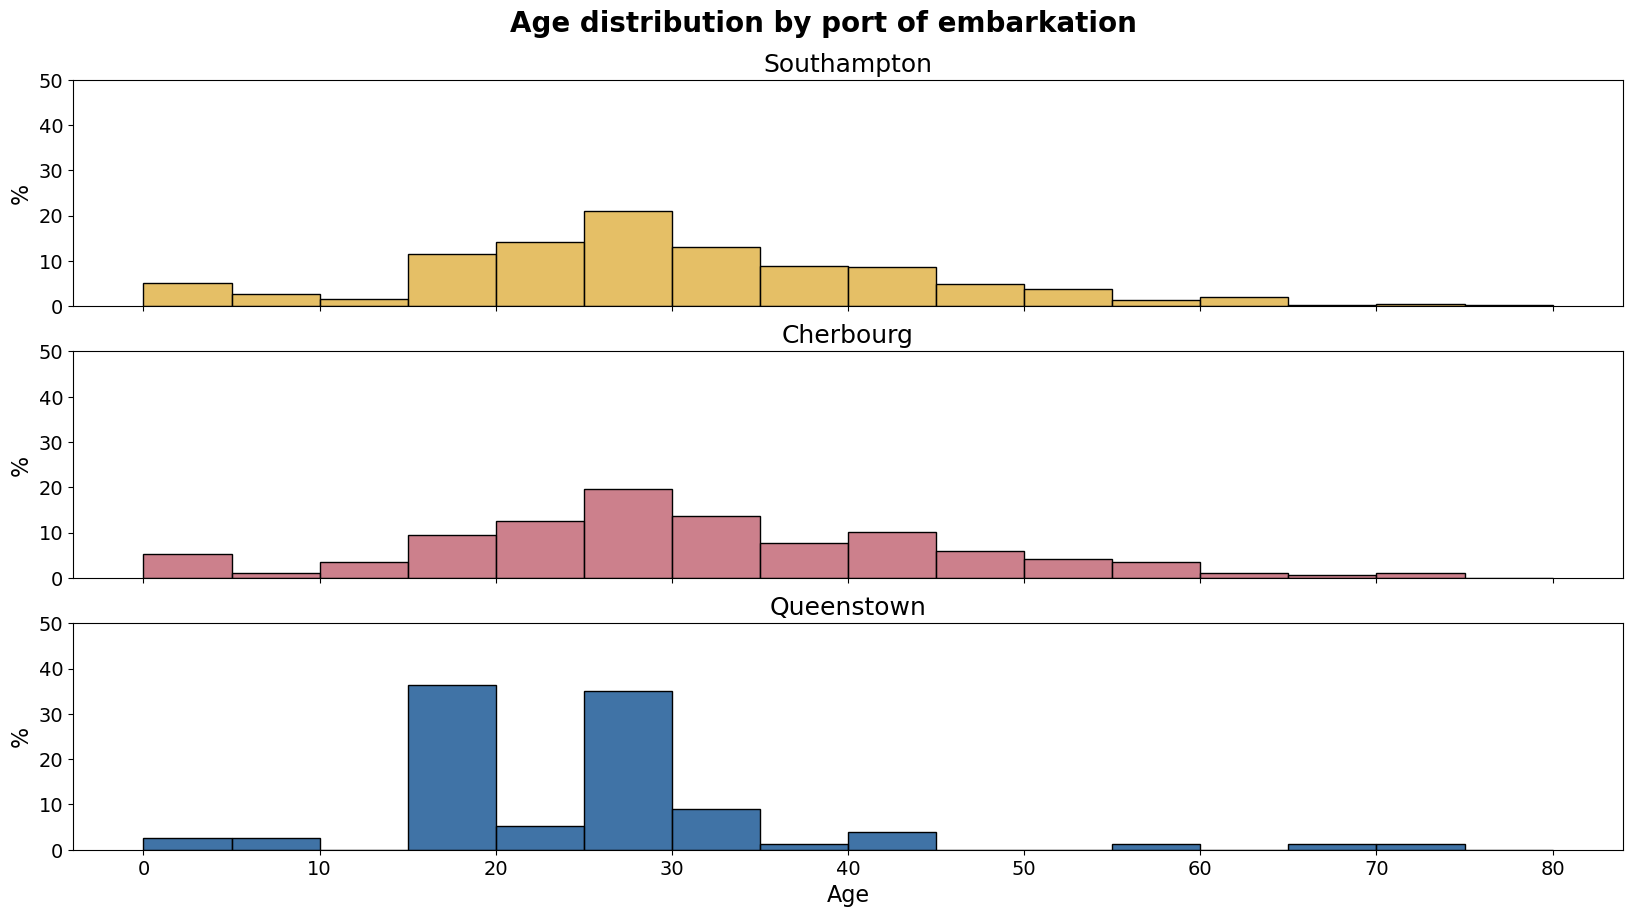

In [828]:
# age distribution by port of embarkation
fig, ax = plt.subplots(3, 1, figsize = (20, 10), sharex = True)

# Southampton
sns.histplot(data = titanic_data[titanic_data['Embarked'] == 'S'],
              x = 'Age',
              bins = range(0, 81, 5),
              color = '#ddaa33',
              stat = 'percent',
              ax = ax[0])

ax[0].set_title('Southampton', fontsize = 18)
ax[0].set_ylabel('%', fontsize = 16)
ax[0].set_ylim(0, 50)
ax[0].tick_params(axis = 'both', labelsize = 14)


# Cherbourg
sns.histplot(data = titanic_data[titanic_data['Embarked'] == 'C'],
              x = 'Age',
              bins = range(0, 81, 5),
              color = '#bb5566', 
              stat = 'percent',
              ax = ax[1])

ax[1].set_title('Cherbourg', fontsize = 18)
ax[1].set_ylabel('%', fontsize = 16)
ax[1].set_ylim(0, 50)
ax[1].tick_params(axis = 'both', labelsize = 14)


# Queenstown
sns.histplot(data = titanic_data[titanic_data['Embarked'] == 'Q'],
              x = 'Age',
              bins = range(0, 81, 5),
              color = '#004488',
              stat = 'percent',
              ax = ax[2])

ax[2].set_title('Queenstown', fontsize = 18)
ax[2].set_xlabel('Age', fontsize = 16)
ax[2].set_ylabel('%', fontsize = 16)
ax[2].set_ylim(0, 50)
ax[2].tick_params(axis = 'both', labelsize = 14)

plt.suptitle('Age distribution by port of embarkation', fontsize = 20, fontweight = 'bold', y = 0.95)

plt.show()

The age distribution proportions for passengers embarking in Southampton and Cherbourg look very similar, with a comparable number of children aged 15 and younger and a majority of passengers aged between 15 and 45 years old. In Queenstown the distribution looks somewhat different, with a majority of passengers either in their late teens or their late 20s.<br>
Thus, it does not seem that age is a factor that explains why passengers departing from Cherbourg had a higher survival rate.

Another possibility is a lower proportion of passengers travelling alone amongst the passengers embarking in the French city, or passengers travelling with 1-3 relatives.

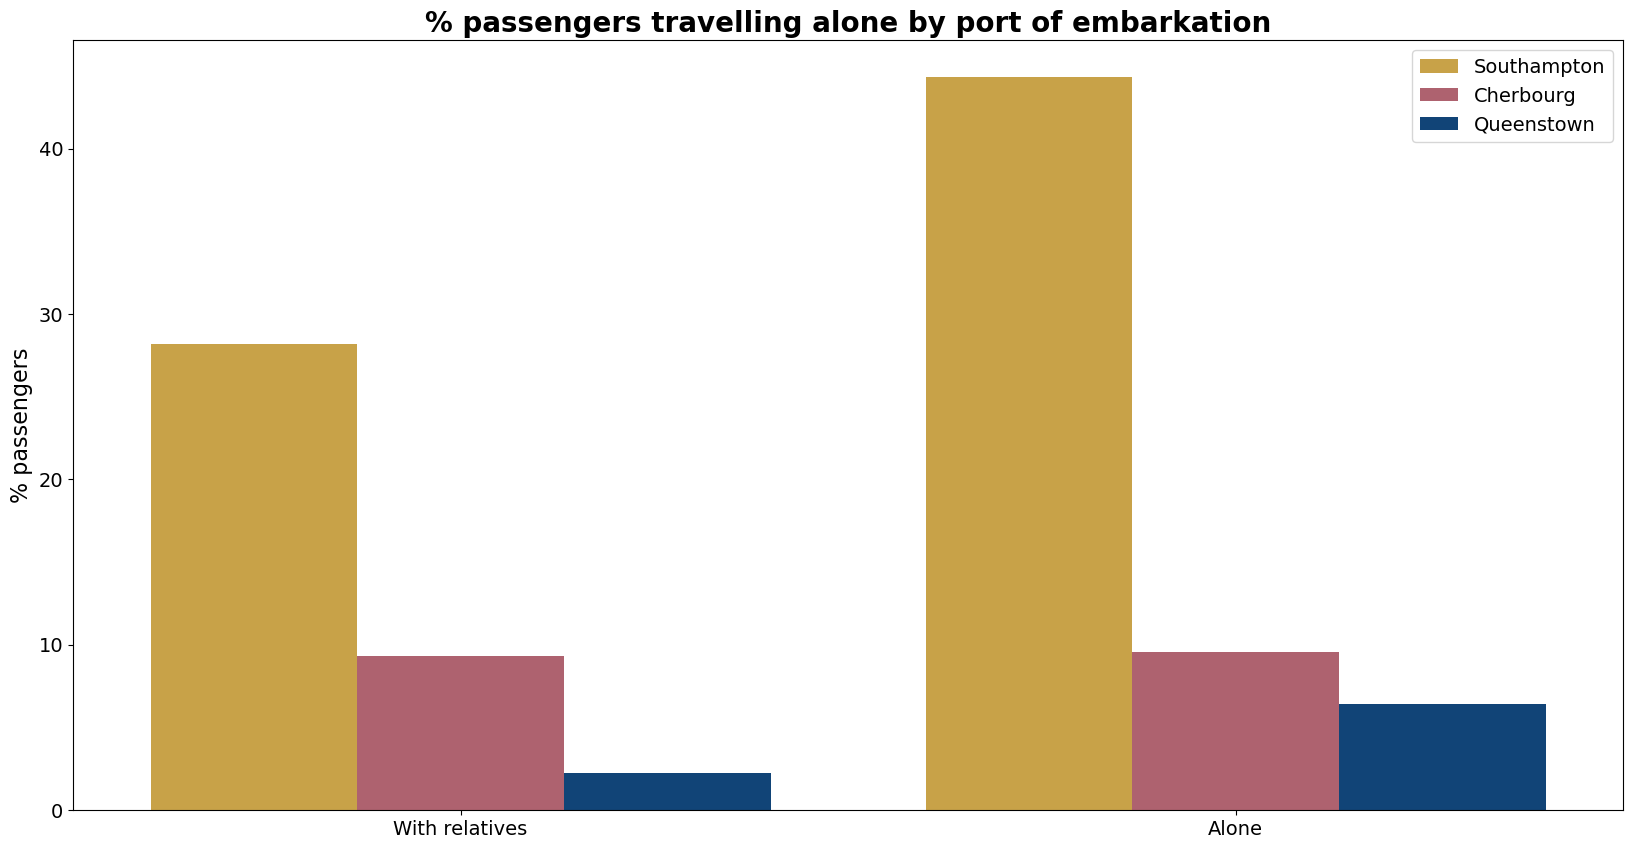

In [831]:
# % passengers travelling alone or with relatives by port of embarkation
plt.figure(figsize = (20, 10))

sns.countplot(data = titanic_data,
             x = 'IsAlone',
             hue = 'Embarked',
             hue_order = ['S', 'C', 'Q'],
             palette = {'S': '#ddaa33', 'C': '#bb5566', 'Q': '#004488'},
             legend = True,
             stat = 'percent')

plt.title('% passengers travelling alone by port of embarkation', fontsize = 20, fontweight = 'bold')
plt.xlabel('')
plt.xticks([0, 1], ['With relatives', 'Alone'])
plt.ylabel('% passengers', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(['Southampton', 'Cherbourg', 'Queenstown'], fontsize = 14)

plt.show()

In [832]:
# proportion of passengers travelling alone or not by port of embarkation
pd.crosstab(titanic_data['Embarked'], titanic_data['IsAlone'], normalize = 0)

IsAlone,0,1
Embarked,,
C,0.494048,0.505952
Q,0.259740,0.740260
S,0.388545,0.611455


Indeed, the port of Cherbourg had the lowest proportion of passengers embarking alone (50.6%), while Queenstown had the largest (74.03%), followed by Southampton (61.15%). When examining how many relatives each passenger was travelling with (below), the largest proportion of those travelling with 1-3 relatives is found among passengers embarking in Cherbourg (48.21%, vs. 30.34% among passengers embarking in Southampton and 19.48% in Queenstown).

In [834]:
# % passengers in different groups depending on number of relatives aboard by port of embarkation
pd.crosstab(titanic_data['Embarked'], \
            pd.cut(titanic_data['RelativesAboard'], bins = [0, 1, 4, 11], include_lowest = True, right = False),
           normalize = 0)

RelativesAboard,"[0, 1)","[1, 4)","[4, 11)"
Embarked,,,
C,0.505952,0.482143,0.011905
Q,0.740260,0.194805,0.064935
S,0.611455,0.303406,0.085139


As shown above, the port of Cherbourg had the lowest proportion of passengers travelling alone and the largest of those travelling with 1-3 relatives. These 2 factors are related to a higher survival rate and possibly contribute to the higher survival rate of passengers embarking in the French city.<br>
Another factor that seemed to have a positive impact in survival was the socio-economic status.

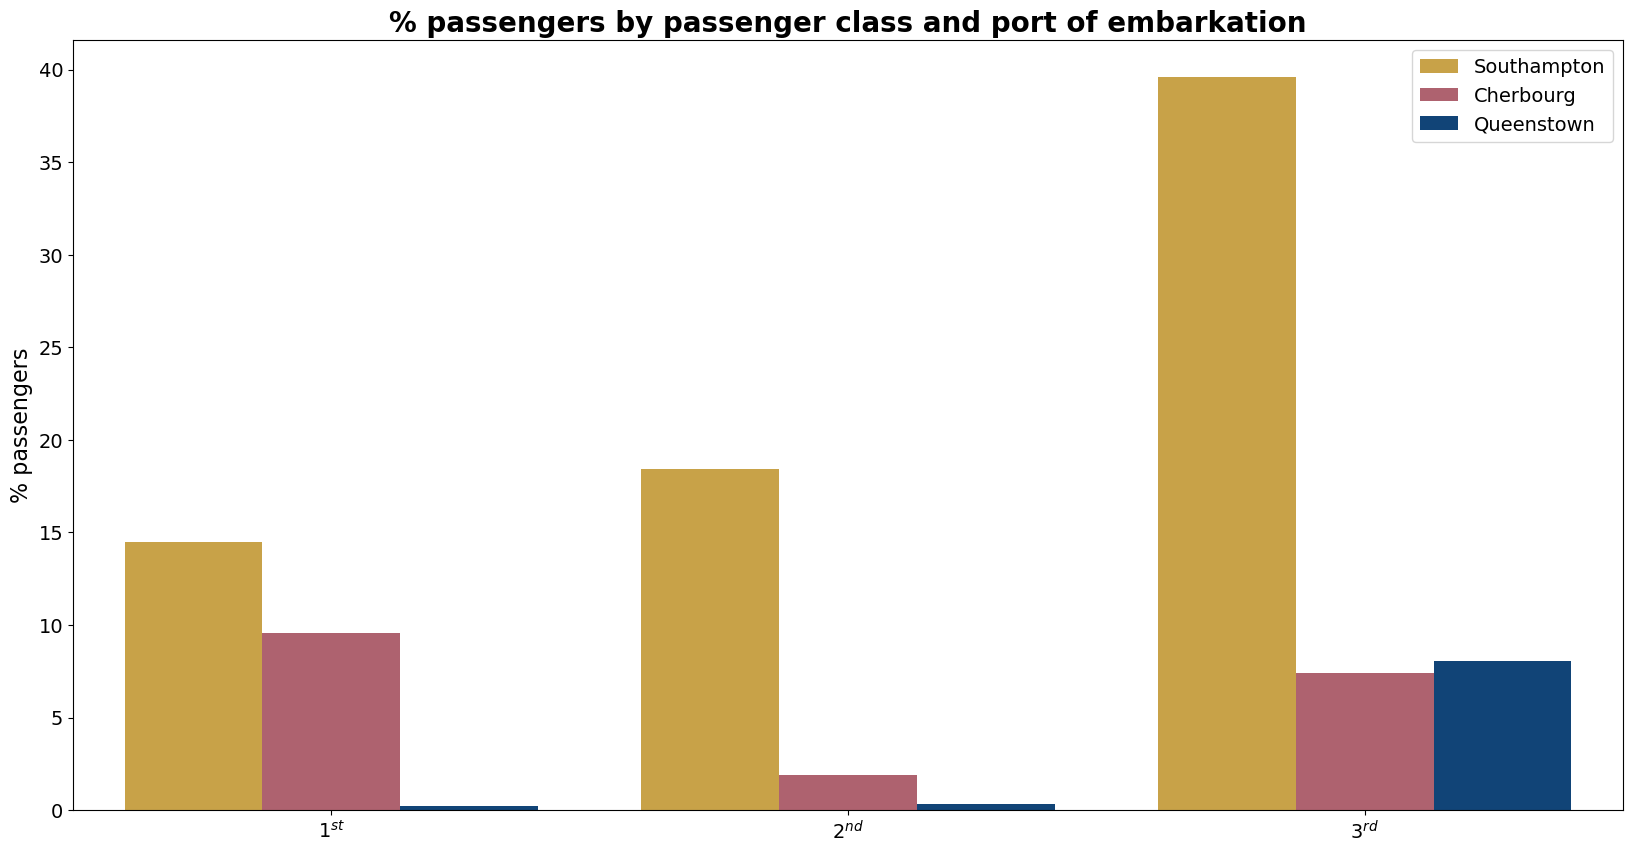

In [836]:
# % passengers by passenger class and port of embarkation
plt.figure(figsize = (20, 10))

sns.countplot(data = titanic_data,
             x = 'Pclass',
             hue = 'Embarked',
             hue_order = ['S', 'C', 'Q'],
             palette = {'S': '#ddaa33', 'C': '#bb5566', 'Q': '#004488'},
             legend = True,
             stat = 'percent')

plt.title('% passengers by passenger class and port of embarkation', fontsize = 20, fontweight = 'bold')
plt.xlabel('')
plt.xticks([0, 1, 2], ['$1^{st}$', '$2^{nd}$', '$3^{rd}$'])
plt.ylabel('% passengers', fontsize = 16)
plt.tick_params(axis = 'both', labelsize = 14)
plt.legend(['Southampton', 'Cherbourg', 'Queenstown'], fontsize = 14)

plt.show()

In [837]:
pd.crosstab(titanic_data['Embarked'], titanic_data['Pclass'], normalize = 0)

Pclass,1,2,3
Embarked,,,
C,0.505952,0.101190,0.392857
Q,0.025974,0.038961,0.935065
S,0.199690,0.253870,0.546440


When looking at the proportion of passengers in the different passenger classes by port of embarkation, the port of Cherbourg had the largest proportion of passengers travelling in 1<sup>st</sup> (50.6% of passengers embarking in this city travelled in 1<sup>st</sup> class). This percentage was significantly lower for the other 2 ports (19.97% in Southampton and 2.6% in Queenstown). Thus, probably this is another factor that explains the higher survival rate seen in passengers that embarked in Cherbourg. As expected, these are the ones who paid a higher price for their ticket (below).

In [839]:
titanic_data.groupby(['Embarked'])['Fare'].mean().sort_values(ascending = False)

Embarked
C    59.954144
S    27.243651
Q    13.276030
Name: Fare, dtype: float64

### Summary of the exploratory data analysis.

After the EDA, some insights can be extracted from the data:
- There is a majority of men in the dataset (577 vs. 314 women).
- The survival rate of passengers in the dataset was 38.38%.
- Most passengers in the dataset were aged between 15 and 45 years old.
- Women had a higher survival rate than men (74.2% vs. 18.89%).
- Children aged 15 or younger were more likely to survive (58.62% vs. 36.19% for passengers older than 15).
- Travelling with 1 to 3 relatives increased the chances of survival. This was especially true for men, with men having 2-3 relatives aboard having a higher survival rate than men travelling alone or with more than 3 family members.
- Having too many family members aboard dramatically reduced the chances of survival.
- Travelling alone had a negative impact in survival for men, but not for women. Women travelling alone had a similar survival rate as those travelling with 1-3 relatives.
- Passengers in 1<sup>st</sup> class had a higher survival rate (62.96%) compared to those in 2<sup>nd</sup> (47.28%) and 3<sup>rd</sup> class (24.24%). This does not correlate with the proportion of women and/or children aged 15 or younger.
- Passengers who paid a higher fare had a higher survival rate. This is related to the fact that passengers that travelled in 1<sup>st</sup> class paid, on average, a higher price for their ticket.
- The majority of passengers in the dataset embarked in Southampton (>72%).
- Passengers embarking in Cherbourg had the highest survival rate (55.36%, vs. 38.96% for passengers embarking in Queenstown and 33.9% for those embarking in Southampton), possibly due to a larger proportion of passengers travelling in 1<sup>st</sup> class and with 1-3 relatives, as well as a lower proportion of passengers travelling alone.

## Model.

I will train the following 7 models:
- Logistic Regression.
- Decision Tree.
- Random Forest Classifier.
- Support Vector Machine.
- Gradient Boosting Machine.
- KNN.
- Naive Bayes.

Finally, I will also combine all of them and make a final prediction for each passenger by majority voting among the 7 trained models.<br>
In this first attempt, I will not do any hyperparameter tuning.

### Data pre-processing.

I will start by creating a copy of the dataset to work on.

In [846]:
# copying the data to create the model
model_data = titanic_data.copy()

# checking the copy
model_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,RelativesAboard
0,0,3,male,22.0,1,0,7.2500,S,0,1
1,1,1,female,38.0,1,0,71.2833,C,0,1
2,1,3,female,26.0,0,0,7.9250,S,1,0
3,1,1,female,35.0,1,0,53.1000,S,0,1
4,0,3,male,35.0,0,0,8.0500,S,1,0


Next, I will do one-hot encoding of the categorical variables.

In [848]:
# Embarked
model_data = pd.get_dummies(model_data, columns = ['Embarked'], drop_first = True, dtype = 'int')

# Sex
model_data['Sex'] = model_data['Sex'].map({'female': 1, 'male': 0})

# checking the changes
model_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,IsAlone,RelativesAboard,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,1,0,1
1,1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,1,26.0,0,0,7.9250,1,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,1,0,1
4,0,3,0,35.0,0,0,8.0500,1,0,0,1


#### Target and feature selection.

The target variable is *Survived* and the features are *Pclass*, *Sex* (encoded), *Age*, *SibSp*, *Parch*, *Fare* and *Embarked* (encoded).

In [851]:
# target and feature selection
X = model_data.drop(['Survived'], axis = 1)   # features
y = model_data['Survived']   # target

#### Data standardisation.

I will now do data standardisation to ensure that all features are on a similar scale.

In [854]:
# initialising the scaler
scaler = StandardScaler()

# scaling the features
X_scaled = scaler.fit_transform(X)

# checking the standardisation
X_scaled

array([[ 0.82737724, -0.73769513, -0.5292143 , ...,  0.05915988,
        -0.30756234,  0.61583843],
       [-1.56610693,  1.35557354,  0.65736597, ...,  0.05915988,
        -0.30756234, -1.62380254],
       [ 0.82737724,  1.35557354, -0.23256923, ..., -0.56097483,
        -0.30756234,  0.61583843],
       ...,
       [ 0.82737724,  1.35557354, -0.82585937, ...,  1.29942929,
        -0.30756234,  0.61583843],
       [-1.56610693, -0.73769513, -0.23256923, ..., -0.56097483,
        -0.30756234, -1.62380254],
       [ 0.82737724, -0.73769513,  0.21239837, ..., -0.56097483,
         3.25137334, -1.62380254]])

#### Train-test split.

In [856]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 11)

#### Logistic Regression.

In [858]:
# initialising the model
lr = LogisticRegression(random_state = 11)

# training
lr.fit(X_train, y_train)

# making predictions
lr_pred = lr.predict(X_test)

# accuracy score
lr_acc = accuracy_score(y_test, lr_pred)

# printing the accuracy score
print(f"Logistic Regression accuracy: {lr_acc}")

Logistic Regression accuracy: 0.8715083798882681


In [859]:
# classification report
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       118
           1       0.84      0.77      0.80        61

    accuracy                           0.87       179
   macro avg       0.86      0.85      0.85       179
weighted avg       0.87      0.87      0.87       179



#### Decision Tree Classifier

In [861]:
# initialising the model
dtree = DecisionTreeClassifier(random_state = 11)

# training
dtree.fit(X_train, y_train)

# predictions
dtree_pred = dtree.predict(X_test)

# accuracy score
dtree_acc = accuracy_score(y_test, dtree_pred)
print(f"Decision Tree accuracy: {dtree_acc}")

Decision Tree accuracy: 0.7821229050279329


In [862]:
# classification report
print(classification_report(y_test, dtree_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       118
           1       0.68      0.69      0.68        61

    accuracy                           0.78       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



#### Random Forest Classifier.

In [864]:
# initialising the model
rfc = RandomForestClassifier(random_state = 11)

# training
rfc.fit(X_train, y_train)

# predictions
rfc_pred = rfc.predict(X_test)

# accuracy score
rfc_acc = accuracy_score(y_test, rfc_pred)
print(f"Random Forest Classifier accuracy: {rfc_acc}")

Random Forest Classifier accuracy: 0.8491620111731844


In [865]:
# classification report
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       118
           1       0.79      0.75      0.77        61

    accuracy                           0.85       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.85      0.85      0.85       179



#### Support Vector Machine.

In [867]:
# initialising the model (RBF kernel)
svc = SVC(kernel = 'rbf',
         random_state = 11)

# training the model
svc.fit(X_train, y_train)

# predictions
svc_pred = svc.predict(X_test)

# accuracy score
svc_acc = accuracy_score(y_test, svc_pred)
svc_acc

0.8715083798882681

In [868]:
# classification report (RBF)
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       118
           1       0.85      0.75      0.80        61

    accuracy                           0.87       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.87      0.87      0.87       179



#### Gradient Boosting Machine.

In [870]:
# initialising the model
gbm = GradientBoostingClassifier(random_state = 11)

# training
gbm.fit(X_train, y_train)

# predictions
gbm_pred = gbm.predict(X_test)

# accuracy score
gbm_acc = accuracy_score(y_test, gbm_pred)
gbm_acc

0.8715083798882681

In [871]:
# classification report
print(classification_report(y_test, gbm_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91       118
           1       0.87      0.74      0.80        61

    accuracy                           0.87       179
   macro avg       0.87      0.84      0.85       179
weighted avg       0.87      0.87      0.87       179



#### Gaussian Naive Bayes.

In [873]:
# initialising the model
gnb = GaussianNB()

# training
gnb.fit(X_train, y_train)

# predictions
gnb_pred = gnb.predict(X_test)

# accuracy score
gnb_acc = accuracy_score(y_test, gnb_pred)
gnb_acc

0.8379888268156425

In [874]:
# classification report
print(classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       118
           1       0.76      0.77      0.76        61

    accuracy                           0.84       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179



#### K-Nearest Neighbour.

In [876]:
# initialising the model
knn = KNeighborsClassifier(n_neighbors = 3)

# training
knn.fit(X_train, y_train)

# predictions
knn_pred = knn.predict(X_test)

# accuracy score
knn_acc = accuracy_score(y_test, knn_pred)
knn_acc

0.8324022346368715

In [877]:
# classification report
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       118
           1       0.75      0.75      0.75        61

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



#### Ensemble.

In [879]:
# stacking predictions
ens = np.array([lr_pred, dtree_pred, rfc_pred, svc_pred, gbm_pred, gnb_pred, knn_pred])

# majority voting
ens_pred, _ = mode(ens, axis = 0)

# accuracy score
ens_acc = accuracy_score(y_test, ens_pred)
ens_acc

0.8659217877094972

In [880]:
# classification report
print(classification_report(y_test, ens_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       118
           1       0.81      0.79      0.80        61

    accuracy                           0.87       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.87      0.87      0.87       179



#### Scores summary.

In [882]:
# Dataframe to summarise the accuracy score of each model
scores = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Support Vector Machine', 'Gradient Boosting Machine',\
             'Gaussian Naive Bayes', 'K-Nearest Neighbour', 'Ensemble'],
    'accuracy': [lr_acc, dtree_acc, rfc_acc, svc_acc, gbm_acc, gnb_acc, knn_acc, ens_acc]
})

# sorting values by accuracy
scores.sort_values(by = ['accuracy'], ascending = False).reset_index(drop = True)

,model,accuracy
0,Logistic Regression,0.871508
1,Support Vector Machine,0.871508
2,Gradient Boosting Machine,0.871508
3,Ensemble,0.865922
4,Random Forest,0.849162
5,Gaussian Naive Bayes,0.837989
6,K-Nearest Neighbour,0.832402
7,Decision Tree,0.782123


Among all models trained, Logistic Regression, Support Vector Machine and Gradient Boost Machine are the models with the highest accuracy (87.15%), whereas Decision Tree is the one with the lowest (78.21%).<br>
The combination of all models (Ensemble) has an 86.59% accuracy.<br>
When looking at the precision and recall, in general all models seem to do better when classifying non survivors.

For next iterations, some hyperparameter tuning could be done. This can be done by doing a grid search of hyperparameters, for example.<br>
Another consideration is the moderate class imbalance in the target variable, with considerably more passengers belonging to the non-survivors class than the survivors one. This could also be optimised when doing the hyperparameter tuning.<br>
Finally, further feature engineering could be another thing to be done in order to improve model performance.